# Project 3

Import some libraries and the datasets

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv # because it is experimental we need this
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss, mean_squared_error,confusion_matrix, classification_report,balanced_accuracy_score, max_error, PredictionErrorDisplay,mean_absolute_error, mean_absolute_percentage_error)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image, Markdown
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import re
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [15]:
# no idea what this is
# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv', quotechar="'")
data_index_2 = data_index_2.drop(columns=['Unnamed: 0'])
nan_template = ~(data_index_2.isna().any(axis=1))
data_index_2 = data_index_2[nan_template] # delete rows with NaN
# precipitation by day and statistics
if True:
    Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')[nan_template]
    Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')[nan_template]
    # maximum temperature by day and statistics
    Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')[nan_template]
    Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')[nan_template]
    # minimum temperature by day and statistics
    Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')[nan_template]
    Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')[nan_template]
    # mean temperature by day and statistics
    Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')[nan_template]
    Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')[nan_template]
    # shortwave radiation flux
    Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')[nan_template]
    Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')[nan_template]

In [3]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [4]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59190, 83)


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
0,-179.75,71.25,0.08,0.37,0.55,0.020,11.0,5.9,0.482,249.88,...,0.0,0.000,0.000,13,13,17,10,Russia,RUS,643
1,-179.75,68.75,0.20,0.48,0.32,0.031,17.0,6.3,0.753,250.64,...,0.0,0.003,0.015,13,11,17,10,Russia,RUS,643
2,-179.75,68.25,0.20,0.48,0.32,0.031,17.0,6.3,0.447,249.84,...,0.0,0.006,0.022,13,11,17,10,Russia,RUS,643
3,-179.75,67.75,0.20,0.48,0.32,0.031,17.0,6.3,0.526,250.84,...,0.0,0.002,0.020,13,11,17,10,Russia,RUS,643
4,-179.75,67.25,0.20,0.48,0.32,0.031,17.0,6.3,0.422,251.42,...,0.0,0.003,0.016,13,11,17,10,Russia,RUS,643


In [5]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

### Pred (Precipitation, mm day-1)
 

In [6]:
print(f'shape: {Predaymean.shape}')
#Predaymean.head()

In [7]:
print(f'shape: {Predaymean_statistics.shape}')
#Predaymean_statistics.head()

### Tmp (Daily mean temperature, K)

In [8]:
print(f'shape: {Tmpdaymean.shape}')
#Tmpdaymean.head()

In [9]:
print(f'shape: {Tmpdaymean_statistics.shape}')
#Tmpdaymean_statistics.head()

### Tmax

In [10]:
print(f'shape: {Tmaxdaymean.shape}')
#Tmaxdaymean.head()

In [11]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
#Tmaxdaymean_statistics.head()

### Tmin

In [12]:
print(f'shape: {Tmindaymean.shape}')
#Tmindaymean.head()

In [13]:
print(f'shape: {Tmindaymean_statistics.shape}')
#Tmindaymean_statistics.head()

### Tswrf (Total shortwave radiation flux, W m-2)

In [14]:
print(f'shape: {Tswrfdaymean.shape}')
#Tswrfdaymean.head()

In [15]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
#Tswrfdaymean_statistics.head()

### County List and binome legend

In [16]:
# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

country_codes = pd.DataFrame(datatable, columns = ['Lon', 'Lat', 'GFED-region', 'Pan_2007', 'ISO3', 'UN'] )  
country_codes = country_codes.drop(index = 0)
country_codes.head()

,Lon,Lat,GFED-region,Pan_2007,ISO3,UN
1,-69.75,-55.25,5,Americas,CHL,152
2,-69.25,-55.25,5,Americas,CHL,152
3,-71.25,-54.75,5,Americas,CHL,152
4,-70.75,-54.75,5,Americas,CHL,152
5,-70.25,-54.75,5,Americas,CHL,152


In [17]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


## Some preparations

### number of samples of different biomes in different coutries

In [ ]:
countrys_sample_size = data_index_2.groupby(['ISO3', 'Biome_obs']).size()   
#countrys_sample_size = pd.DataFrame(countrys_sample_size)
#countrys_sample_size.columns = [ "Size"]           # Maybe solve later
countrys_sample_size.head()

In [ ]:
# Samply size for countries
countrys_sample_size.at["EGY"]

### Plot and table generation

In [103]:
# Names my have to be improved
def df_to_latex(df, filename = 'mytable', caption=''):  
    s = df.style.to_latex(
    # column_format="rrrrr",#  position="h", position_float="centering",
    hrules=True,
    multirow_align="t", multicol_align="r"
    )  
        
    with open('../table/' + filename + '.tex', 'w') as f:
        f.write(s)  
    

In [4]:
def save_plot(figure, figurename = 'my_plot'):
    figure.savefig('../plots/' + figurename + '.pdf', bbox_inches='tight')

## test
#save_plot(fig, figurename ='worldmap')

Plotting the map

In [3]:
biome_data_file = '../Project_datasets/legend of biomes.txt'

biome_colors = {}
biome_names = {}

def parse_rgb_value(value):
    # Check if the value starts with a dot and add a leading zero if needed
    if value.startswith('.'):
        value = '0' + value
    return float(value)

with open(biome_data_file, 'r') as file:
    lines = file.readlines()
    i = 0
    while i < len(lines):
        
        biome_number, biome_name = lines[i].strip().split(maxsplit=1)
        
        rgb_values = list(map(parse_rgb_value, lines[i + 1].strip().split()))
        #rgb_tuple = tuple(int(val * 255) for val in rgb_values)   # no need to do this.....indexerror will arise
        
        # Add data to dictionaries
        biome_colors[int(biome_number)] = rgb_values
        biome_names[int(biome_number)] = biome_name
        
        # Move to the next biome data
        i += 2


In [ ]:
def plot_region(region=None, Y_hat=None, parameter='Biome_obs', plot_name=None):
    """
    region: bolean list of regions to be plotted
    Y_hat: values to compare to
    """
    if not np.any(region): region = np.ones((data_index_2.shape[0],),dtype=bool)
    if not np.any(Y_hat): Y_hat=np.asarray(data_index_2.loc[region][parameter])
    # check if the region is russia
    if ((data_index_2['ISO3'] == 'RUS')==region).all():
        # cut off that bit at alaska
        Y_hat = Y_hat.loc[data_index_2.loc[region]['Lon']>-50]
        region = region & (data_index_2['Lon'] >-50)
    Y_hat = pd.DataFrame(Y_hat, index=data_index_2.loc[region].index, columns=[parameter])
    lon_lat={}
    for i,sel in enumerate(['Lon', 'Lat']):
        lon_lat[i] = data_index_2.loc[region][sel]


    biome = data_index_2[parameter]

    fig, ax = plt.subplots(figsize=(12, 12),dpi=300)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(ax=ax, color='white', edgecolor='black')
    
    # Now we crop the world to focus on the locations whose biome was predicted wrongly
    longer_side=0
    for i,func in enumerate([ax.set_xlim, ax.set_ylim]):
        max_lon_lat = max(lon_lat[i])
        min_lon_lat = min(lon_lat[i])
        func((min_lon_lat-2,max_lon_lat+2)) #crop image
        longer_side=max(longer_side,max_lon_lat-min_lon_lat)


    geometry = [Point(lon, lat) for lon, lat in zip(lon_lat[0], lon_lat[1])]
    gdf = gpd.GeoDataFrame(data_index_2.loc[region][parameter], geometry=geometry)
    gdf_Y_hat = gpd.GeoDataFrame(Y_hat[parameter], geometry=geometry)

    markersize = 30000/(longer_side**2)
    # Plot points with different colors based on biome
    for b in set(biome): 
        print(b) #test the position
        gdf_b = gdf[(gdf[parameter] == b) & (gdf_Y_hat[parameter]==gdf[parameter])]
        gdf_b.plot(ax=ax, color=biome_colors[b], label=biome_names[b],marker='s', markersize=markersize)

        gdf_err = gdf[(gdf[parameter] == b) & (gdf_Y_hat[parameter]!=gdf[parameter])]
        gdf_err.plot(ax=ax, color='black', label='wrongly categorised', marker='s',markersize=markersize)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # Add legend
    #plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # Add a title
    plt.title('Biome Map')

    # Show the map
    plt.show()
    if plot_name: plt.savefig(f'{plot_name}_map.pdf', dpi=300, bbox_inches='tight')

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


1
2
3
5


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


6
7
8
9
10
11
12


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


13
14


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


15
16


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


17


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


18


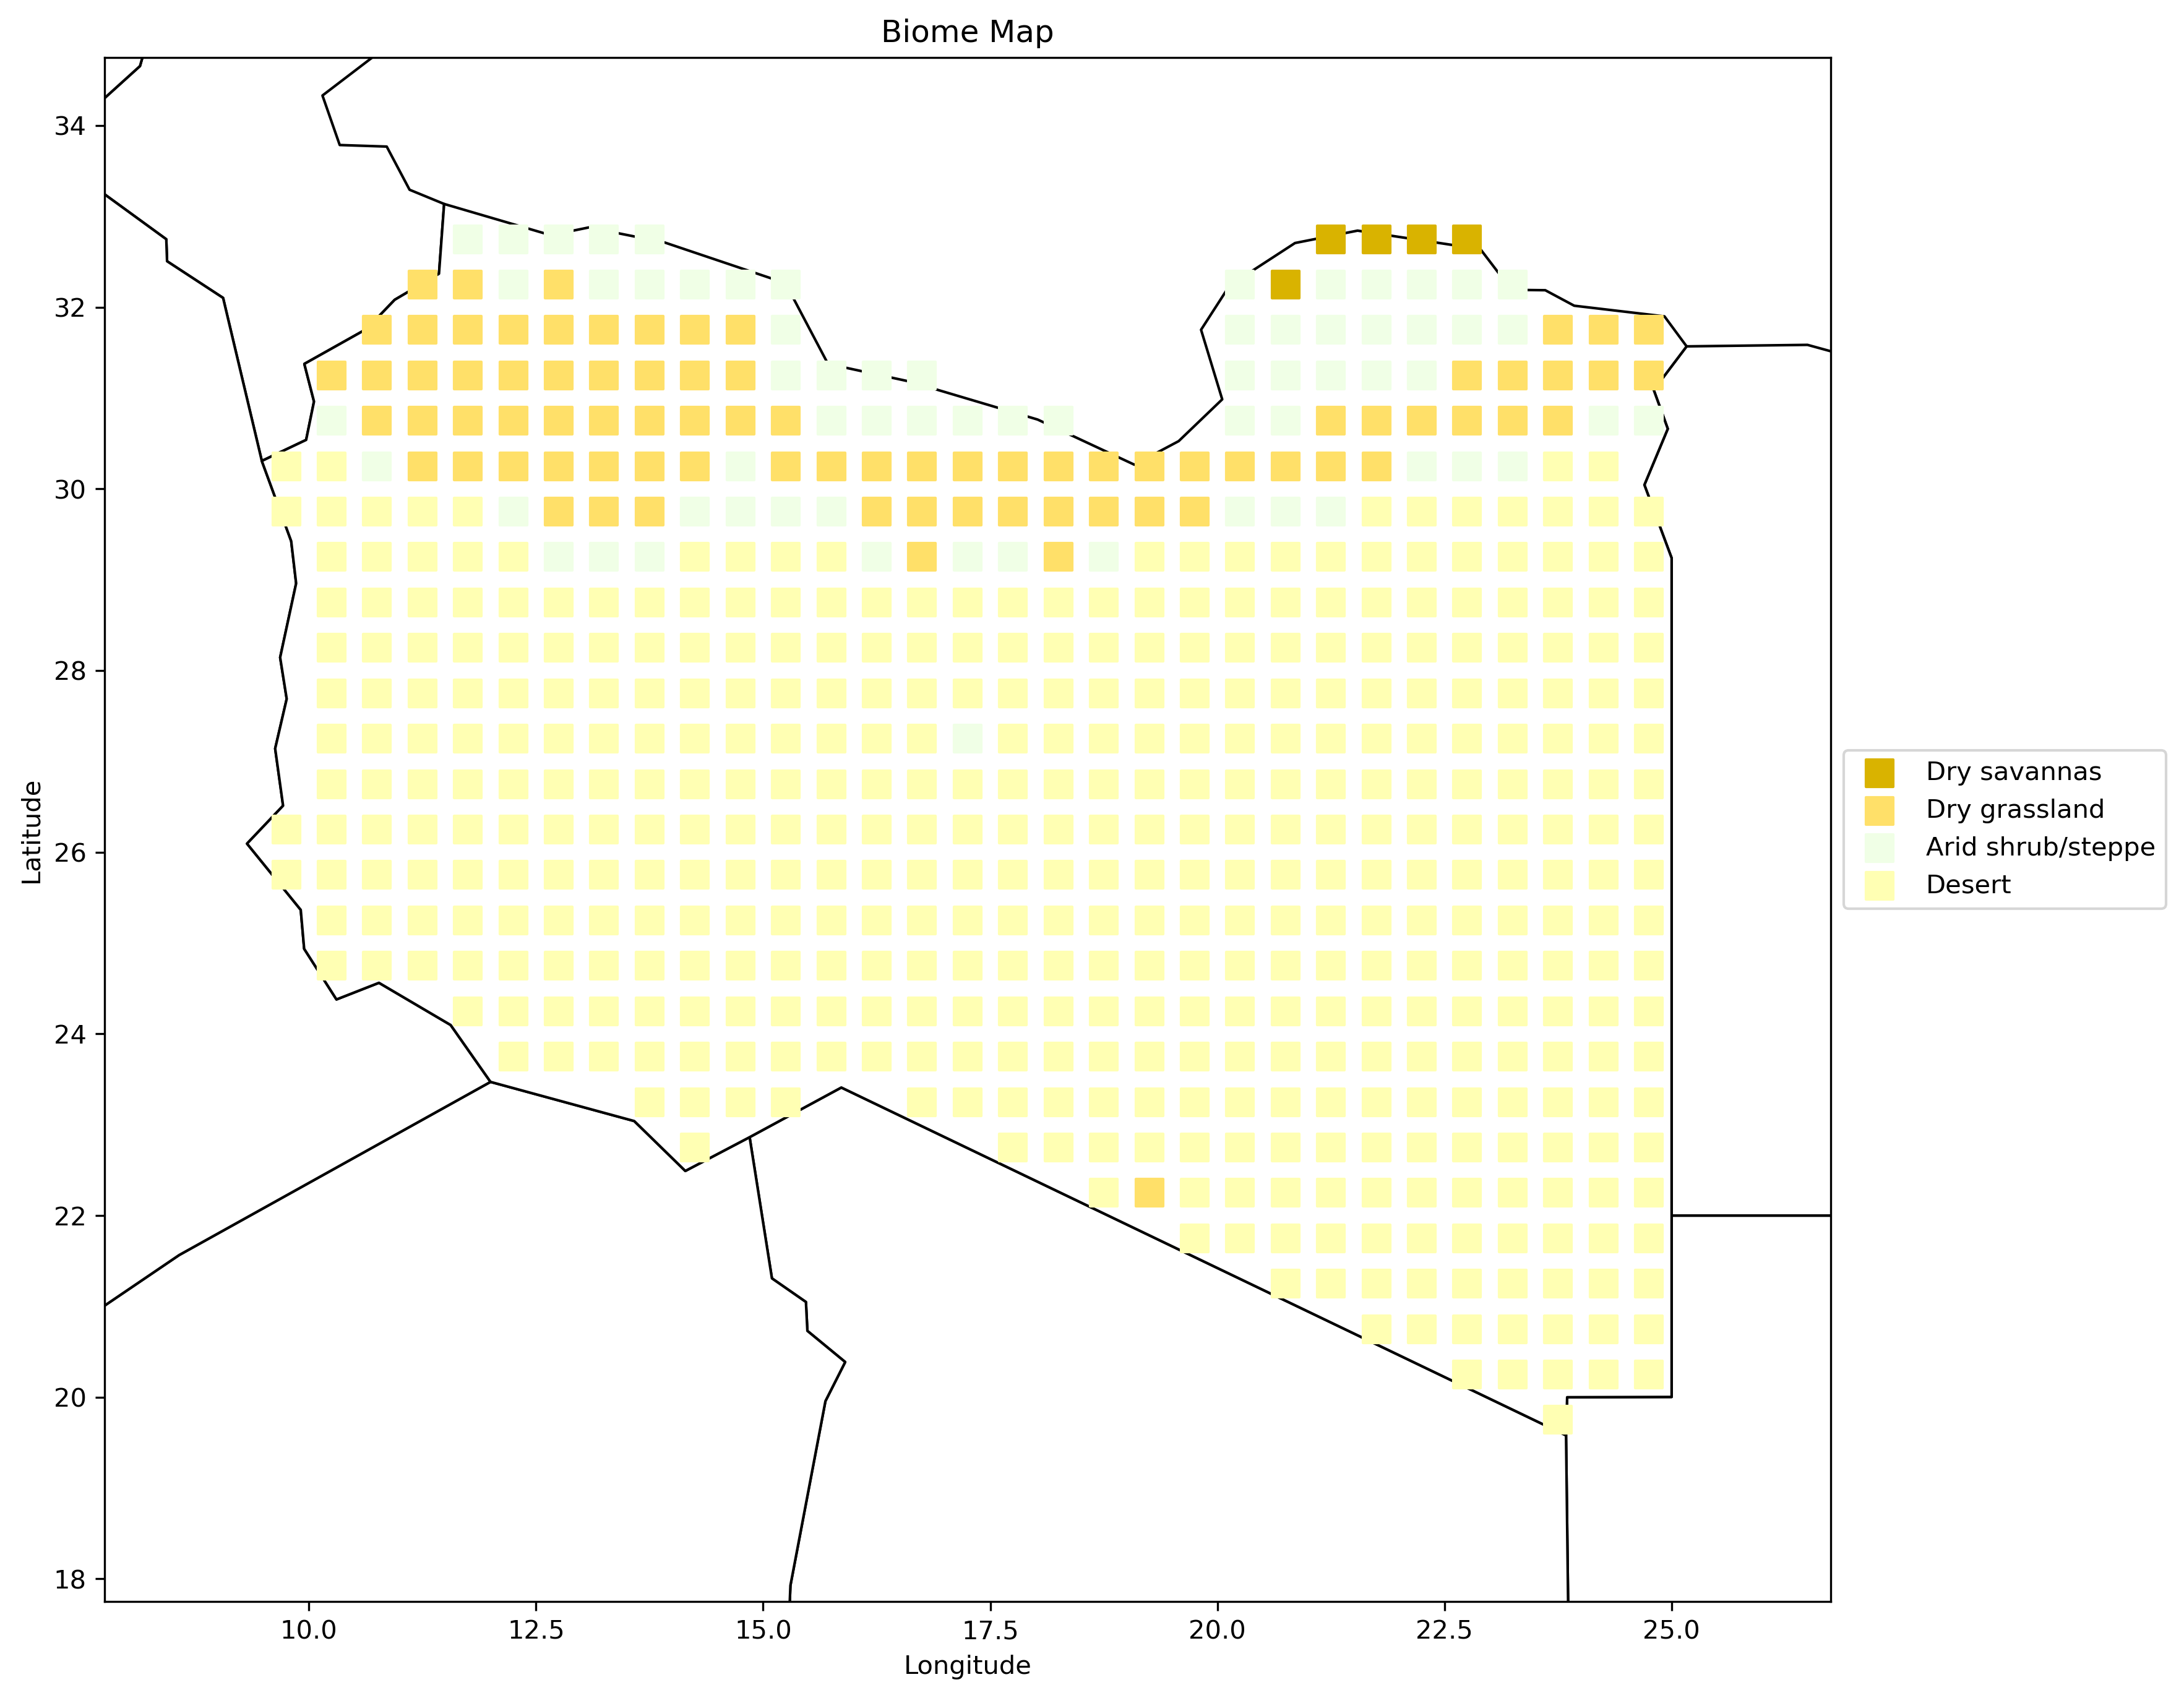

In [150]:
plot_region() # plot the world

### Plot function for statistics

In [12]:
def plot_statistics(data, name_data = 'data'):
    
    obs_data = "Biome_obs"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    obs_data = "Biome_Cmax"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_Pan_2007"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'Pan_2007', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_ISO3"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'ISO3', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## scatterplot biome_Cmax and biome_LAI
    obs_data = "Biome_obs_Biome_Cmax"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_Cmax", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    
    '''
    obs_data = "Biome_obs_Biome_LAI"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_LAI", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    '''
    
    # NPP
    obs_data = "NPP"
    fig, axs = plt.subplots( 1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,  kde=True, ax=axs[0]) #stat="density", kde=True,, log_scale=True
    sns.ecdfplot(data, x="NPP", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)
    
    #"VegC"
    obs_data = "VegC"
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,   kde=True, ax=axs[0]) #stat="density", kde=True,binwidth=1,
    sns.ecdfplot(data, x="VegC", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)

## Section 2: Visualisation


In [ ]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']

features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]

liste = ['Lat', 'Lon', 'UN', 'GFED-region', 'Biome_obs', 'Biome_LAI', 'Biome_Cmax']+features_weather

print(data_index_2.head())
print(data_index_2.drop(liste, axis=1).describe())

Countplot to count the number of data for each biom: 

In [ ]:
#sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

In [ ]:
plot_statistics(data_index_2)

Biome with index 4?

In [ ]:
data_index_2.loc[data_index_2['Biome_obs'] == 4]

## Functions for Classifiaction and Regression

### Generate test and train sets

In [95]:
# the following function generates X_test, Y_test and X_train, Y_train for the binary classification
def model_create_XY(region_train, region_test, \
                     drop_columns=[], use_columns=None, \
                        objective='Biome_obs', objective_list=None, continuous_Y=False,
                        objective_test=None, drop_LPG_guess=True):
      
      drop_columns = drop_columns.copy() + [objective] # we would not want our objective to appear in the training data

      # restrict to two biomes, restrict to country codes, remove any rows with NaN
      if not continuous_Y:
            if not objective_list: objective_list=list(data_index_2.loc[region_train][objective].drop_duplicates())
            relevant_data_train = data_index_2.loc[data_index_2[objective].isin(objective_list)] # restrict to given biomes
            # in case we want to use LPJ_guess output, write LPJ_ before the objective_list
            relevant_data_test = data_index_2.loc[data_index_2[objective_test].isin(objective_list)] # restrict to given biomes
      else:
            relevant_data_train = data_index_2
            relevant_data_test = data_index_2

                  
      relevant_data_train = relevant_data_train.loc[region_train] # restrict to training country
      relevant_data_test = relevant_data_test.loc[region_test] # restrict to test country

      drop_columns += ['MaxBiomeLAI','Biome_obs','Biome_LAI','Biome_Cmax',
                       'Lon','Lat','Pan_2007','ISO3','UN','MaxBiomeCmax']
      if drop_LPG_guess: drop_columns += ['CN','pH','cellfraction','NPP','VegC','SoilC','LitterC','SoilR','GFED-region'] # drop these columns
      if use_columns:
            X_train = relevant_data_train[use_columns]
            X_test = relevant_data_test[use_columns]
      else:
            X_train = relevant_data_train.drop(columns=drop_columns)
            X_test = relevant_data_test.drop(columns=drop_columns)

      feature_names = list(X_train.columns)

      Y_train = relevant_data_train[objective]
      Y_test = relevant_data_test[objective_test]

      print(f"length of training data: {Y_train.shape[0]}")
      print(f"length of testing data: {Y_test.shape[0]}")
      

      return X_train, X_test, Y_train, Y_test, feature_names

### Plot Feature importance (Permutation importance vs. purity importance)

Important Notes
- The more accurate model is, the more trustworthy computed importances are.
- The computed importances describe how important features are for the machine learning model. It is an approximation of how important features are in the data.


In [96]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y,  n_repeats=10, random_state=42, n_jobs=2) # n_repeats=10, random_state=42, n_jobs=2
    perm_sorted_idx = result.importances_mean.argsort()
    
    x_val = X.columns[perm_sorted_idx]
    y_val = result.importances[perm_sorted_idx].mean(axis=1).T
    
    if len(y_val) > 10:
        x_val = x_val[:5].union(x_val[-5:])
        y_val = np.concatenate([y_val[:5],y_val[-5:]])
    ax.barh(x_val, y_val)
    ax.tick_params(axis='y', which = 'minor', labelsize=10)
    #ax.axvline(x=0, color="k", linestyle="--")
    return ax

def plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, experiment_name):

    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    # tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    # tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
    y = mdi_importances.sort_values()
    y = pd.concat([y[:5],y[-5:]])
    y.plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X_train, Y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy ")
    #fig.suptitle(
     #   "Impurity-based vs. permutation importances on multicollinear features"
    #)
    plot_permutation_importance(clf, X_test, Y_test, ax3)
    ax3.set_xlabel("Decrease in accuracy")
    _ = fig.tight_layout()
    save_plot(fig, figurename = 'histogramm_feature_imp'+ experiment_name )
    return fig

def clustering(clf, X_train, X_test,  Y_train, Y_test, experiment_name, continuous_Y=False):
    
    
    fig, (ax1) = plt.subplots( figsize=(6,7))
    corr = spearmanr(X_train).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
    )

    save_plot(fig, figurename = 'dendogramm_feature_imp'+ experiment_name )
    dendro_idx = np.arange(0, len(dendro["ivl"]))
    
    cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X_train.columns[selected_features]
    selected_features_names = selected_features_names.tolist()
    
    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]

    clf_sel = clf

    clf_sel.fit(X_train_sel, Y_train)
    if not continuous_Y:
        print(
            "Baseline accuracy on test data with features removed:"
            f" {accuracy_score(Y_test, clf_sel.predict(X_test_sel)):.4}"
            "Baseline balanced accuracy on test data with features removed:"
            f" {balanced_accuracy_score(Y_test, clf_sel.predict(X_test_sel)):.4}"
        )
    
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_permutation_importance(clf_sel, X_test_sel, Y_test, ax)
    #ax.set_title("Permutation Importances on selected subset of features\n(test set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    save_plot(fig, figurename = 'histogramm_feature_imp_clustered'+ experiment_name )
    plt.show()

### Classification

In [120]:
# the following generates, trains and evaluates the model
def model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False, feature_plots=False, experiment_name=None,
                         plotmap=False, objective_test=None):

    clf = RandomForestClassifier(random_state=0)
    
    if hyperparameter_tuning==4: # for testing parameters manually
        clf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=100, min_samples_leaf=1)
    elif hyperparameter_tuning:
        X_hyper, Y_hyper = X_train, Y_train
        # X_hyper,_,Y_hyper,_ = skm.train_test_split(X_train, Y_train, train_size=300,random_state=0)
        kfold3 = skm.KFold(3,
                        random_state=1,
                        shuffle=True) # let's try fewer fold to save running time

        fineness = 10 # determines how many parameters should be tested
        params = {
                'max_depth': np.linspace(5, 15, 1).astype('int'), # (5,15)
                'n_estimators': np.linspace(50, 150, fineness).astype('int'), #50, 150 (10,40) CV number of trees, keep this low for part 4
                'min_samples_leaf': np.linspace(1, 5, fineness).astype('int'), # minimum leaf number
                }
        if False:
            rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3 )
        else:
            # Alternatively use HalvingGridSearchCV which is equally abismal in its performance
            rfc_gscv = HalvingGridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3, min_resources=20, max_resources=30)
        
        # Fit the model
        model_rfc = rfc_gscv.fit(X_hyper, Y_hyper)

        # Model best estimator
        max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
        max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
        min_samples_leaf= model_rfc.best_estimator_.get_params()["min_samples_leaf"]
        max_cvs= rfc_gscv.best_score_
        print("Max Depth: ", max_depths)
        print("Max Trees: ",max_trees)
        print("Min Leafs: ",min_samples_leaf)
        print("Max CV: ",max_cvs)

        clf = RandomForestClassifier(random_state=0, max_depth=max_depths, n_estimators=max_trees, min_samples_leaf=min_samples_leaf)

    clf.fit(X_train, Y_train)


    # Some performance 
    score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    balance_score_rfc_train = balanced_accuracy_score(Y_train, clf.predict(X_train))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_train))
    
    kfold = skm.KFold(3, random_state=1, shuffle=True)
    # This becomes computationally quite expensive for large training sets
    scores_rfc_val = cross_val_score(clf, X_train, Y_train, cv=kfold)
    print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))

    score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))
    balance_score_rfc_test = balanced_accuracy_score(Y_test, clf.predict(X_test))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_test))
    
    # confusion table
    display(Markdown('---\n The confusion table'))
    conf_table = confusion_table(clf.predict(X_test),
                            Y_test)
    display(conf_table)
    if experiment_name:
        df_to_latex(conf_table, f'{experiment_name}_confTable', caption='Confusion matrix.')
    
    Y_hat = clf.predict(X_test)
    classreport = classification_report(Y_test, Y_hat, zero_division = np.nan, output_dict=True)
    classreport = pd.DataFrame(classreport).transpose()
    display(classreport)
    if experiment_name:
        df_to_latex(classreport, f'{experiment_name}_classreport')
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = clf.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    display(feature_imp)
    if experiment_name:
        df_to_latex(feature_imp, f'{experiment_name}_featureImportance')
    

    region_test = np.zeros((data_index_2.shape[0],),dtype=bool)
    region_test[np.asarray(X_test.reset_index()['index'])]=True
    if plotmap:
        plot_region(region_test, Y_hat, objective_test, f'{experiment_name}_error')
    
    if feature_plots:
        # Plot Impurity-based vs. Permutation importance
        plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, experiment_name)
        
        clustering(clf, X_train, X_test,  Y_train, Y_test,  experiment_name)
        
    display(Markdown('---'))

    # return in the format
    # ['accuracy, train', 'balanced accuracy, train', 'cross val accuracy, train',
    #  'accuracy, test', 'balanced accuracy, test']

    return [score_rfc_train ,balance_score_rfc_train, scores_rfc_val, 
            score_rfc_test, balance_score_rfc_test]

### Regression

In [109]:
def regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False, feature_plots=False, experiment_name=None):
    reg = RandomForestRegressor()
    reg.fit(X_train, Y_train)

    score_reg_train = reg.score(X_train, Y_train)
    #Return the coefficient of determination of the prediction (R^2 score)
    
    print('R^2 Score of RandomForestRegressor on train data: {:.4f}'.format(score_reg_train))
    # The following takes way to long for large training sets
    # kfold = skm.KFold(3, random_state=1, shuffle=True)
    # scores_reg_val = cross_val_score(reg, X_train, Y_train, cv=kfold)
    # print("Accuracy RandomForestRegressor on cross validation: %0.4f ( %0.2f)" % (scores_reg_val.mean(), scores_reg_val.std()))
    score_reg_test = reg.score(X_test, Y_test)
    print('R^2 Score of RandomForestRegressor on test data: {:.4f}'.format(score_reg_test))

    # MSE
    Y_hat = reg.predict(X_test)
    mse = np.mean((Y_test - Y_hat)**2)
    print(f'MSE for test data {mse}')

    mse2 = mean_squared_error(Y_test,Y_hat)
    print(f'MSE (with sktfct) for test  data {mse2}')

    # SQRT(MSE)
    sqrtmse = np.sqrt(mse)
    print(f'sqrt(MSE) for test data {sqrtmse}')
    
    # maximum Error
    max_err = max_error(Y_test, Y_hat)
    print(f'max error for test data {max_err}')

    # mean absolute error
    mean_abs_err = mean_absolute_error(Y_test, Y_hat)
    print(f'mean abs error for test data {mean_abs_err}')

    #PredictionErrorDisplay(Y_test, Y_hat)

    # fig, ax = subplots()
    plt_data = pd.DataFrame(np.concatenate([[Y_hat],[Y_test]])).transpose()
    plt_data = plt_data.rename(columns={0:'Y_hat',1:'Y_test'})
    # ax.scatter(Y_hat, Y_test)
    ax = sns.relplot(data=plt_data,x='Y_hat',y='Y_test').ax
    ax.set_xlabel('predicted sample $\hat{Y}$')
    ax.set_ylabel('exact sample $Y_{test}$')
    maxval = max([np.max(Y_test),np.max(Y_hat)])
    ax.plot([0,maxval],[0,maxval],color='red',markersize=1)
    if experiment_name: save_plot(plt.gcf(), f'{experiment_name}_regressionPlot')

    # fig, ax = plt.subplots()
    # ax.hist(Y_test-Y_hat, bins=50, density=True)
    ax = sns.displot(Y_test-Y_hat, kde=True).ax
    ax.set_xlabel('residue $Y_{test}-\hat{Y}$')
    ax.set_ylabel('Number of samples')
    if experiment_name: save_plot(plt.gcf(), f'{experiment_name}_residualDistr')
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = reg.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':reg.feature_importances_},
    index=feature_names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    display(feature_imp)
    if experiment_name:
        df_to_latex(feature_imp, f'{experiment_name}_featureImportance')

    
    if feature_plots:
        # Plot Impurity-based vs. Permutation importance
        plot_permutation_importance_big_graph(reg, X_train, X_test,  Y_train, Y_test, experiment_name)
        
        clustering(reg, X_train, X_test,  Y_train, Y_test,  experiment_name, True)
    display(Markdown('---'))
    # ['R^2 score, train', 'score, test', 'MSE, test', 'MSE sktfct, test', 'sqrt(MSE)', 'max err', 'mean abs err']
    return [score_reg_train, score_reg_test, mse, mse2, sqrtmse, max_err, mean_abs_err]
    

about R2 score - which is the accuracz in the regression case: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion. (Wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination)

### Run model 
continuous_Y = True gives regression, else classification



In [110]:

# run the training data, test data and the model
def model_run(region_train, region_test, objective='Biome_obs', objective_list=None, \
                drop_columns=[], use_columns=None, \
                hyperparameter_tuning=False, continuous_Y=False, objective_test=None, \
                    feature_plots=False, experiment_name=None, drop_LPG_guess=True, plotmap=False):
    if not objective_test: objective_test = objective
    X_train, X_test, Y_train, Y_test, feature_names = model_create_XY(region_train, \
                        region_test, drop_columns, use_columns, objective, \
                              objective_list, continuous_Y, objective_test, drop_LPG_guess)

    if continuous_Y:
        return regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning, feature_plots, experiment_name)
    else:
        return model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning, feature_plots, experiment_name, plotmap,
                         objective_test)

## Section 3: Binary classification

We saw that `NaN` appeard somewhere in `data_index_2`. The following is to find out where it occurs.

In [ ]:
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

Choose countries. Random.org gave us the biomes
- 17: desert
- 16: Arid shrub/steppe

In [101]:
biome_list_3 = [17,16] # our chosen biomes

Countplot: 

In [ ]:
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list_3)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN

In [ ]:
#plot_statistics(relevant_data, name_data = 'Section3Biome17_and_16')

Thus we choose Egypt to train and China as test.

In [18]:
region_train_3 = data_index_2['ISO3'] == 'EGY' # egypt is the chosen one
region_test_3 = data_index_2['ISO3'] == 'LBY' # libya is the chosen one

In [ ]:
# plot the data
data1 = relevant_data.loc[region_train_3] 
data2 = relevant_data.loc[region_test_3]

data = pd.concat([data1,data2])
#plot_statistics(data, name_data = 'Section3EGY-CHN')

In [69]:
def plot_climate_diagramm(region, figname=None):
    fig, ax1=plt.subplots()

    tmp = Tmpdaymean.loc[region].transpose()[2:]
    tmp.reset_index(inplace=True, drop=True)
    tmp = tmp.stack(level=0).droplevel(1)
    tmp_df = pd.DataFrame({'day':tmp.index, 'tmp':tmp.values})
    tmp_df['tmp'] -= 273.15
    p1 = sns.lineplot(ax=ax1, data=tmp_df, x="day", y="tmp", color='red')

    ax2 =ax1.twinx()
    tmp = Predaymean.loc[region].transpose()[2:]
    tmp.reset_index(inplace=True, drop=True)
    tmp = tmp.stack(level=0).droplevel(1)
    tmp_df = pd.DataFrame({'day':tmp.index, 'prec':tmp.values})
    p2 = sns.lineplot(ax=ax2, data=tmp_df, x="day", y="prec", color='blue')

    ax3 = ax1.twinx()
    tmp = Tswrfdaymean.loc[region].transpose()[2:]
    tmp.reset_index(inplace=True, drop=True)
    tmp = tmp.stack(level=0).droplevel(1)
    tmp_df = pd.DataFrame({'day':tmp.index, 'tmp':tmp.values})
    p3 = sns.lineplot(ax=ax3, data=tmp_df, x="day", y="tmp", color='orange')

    ax3.spines['right'].set_position(('outward', 60))

    ax1.yaxis.label.set_color('red')
    ax2.yaxis.label.set_color('blue')
    ax3.yaxis.label.set_color('orange')

    ax1.set_ylabel('Temperature (C)')
    ax2.set_ylabel('Precipitation (mm) / day')
    ax3.set_ylabel('Radiation ($W/m^2$) / day')

    if figname: save_plot(plt.gcf(), f'climate_{figname}')

    # fig, ax=plt.subplots()

    # ax.set_ylabel('Radiation ($W/m^2$) / day')
    # if figname: save_plot(plt.gcf(), f'radiation_{figname}')


Plot climate diagramms

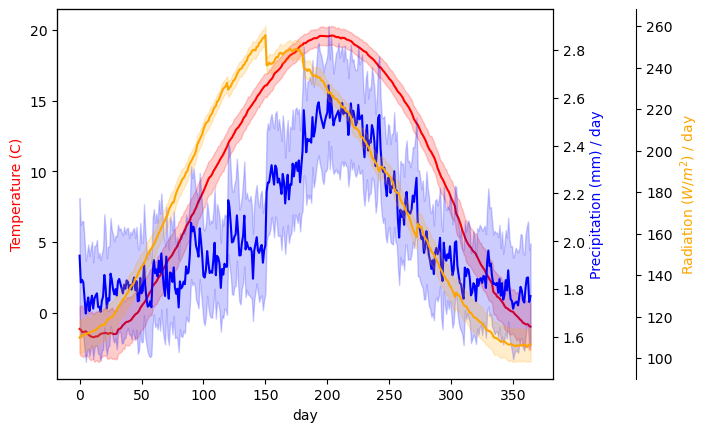

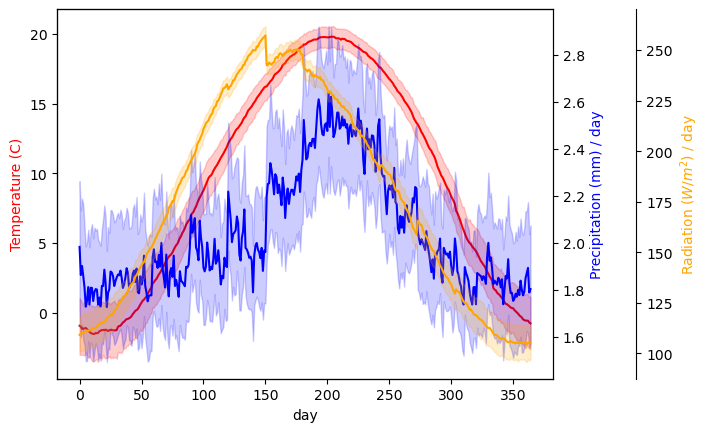

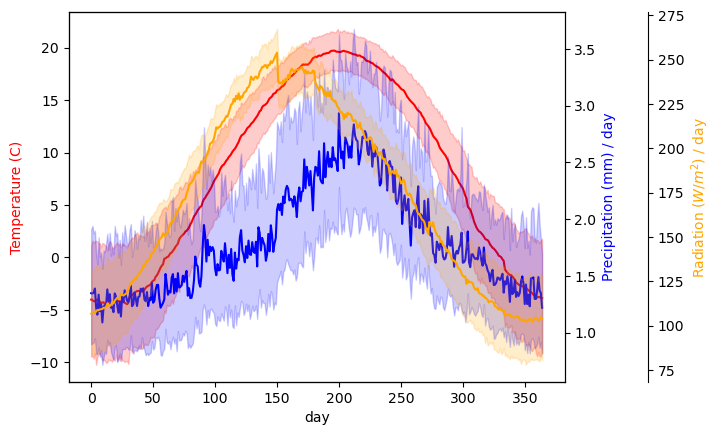

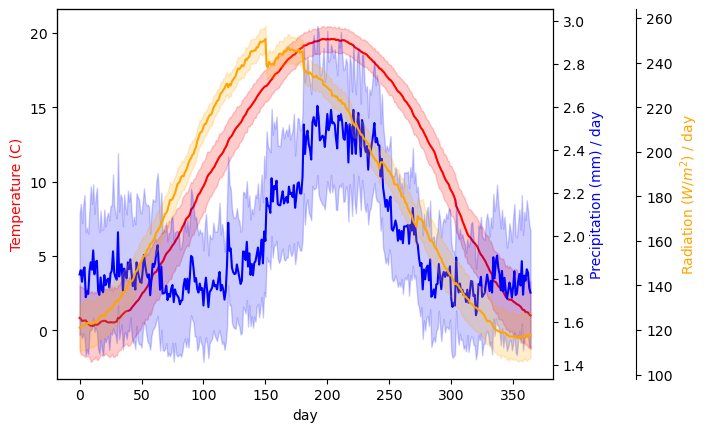

In [70]:
plot_climate_diagramm(region_test_3, 'egypt')
plot_climate_diagramm(region_test_3 & (data_index_2['Biome_obs']==17), 'egypt_desert')
plot_climate_diagramm(region_test_3 & (data_index_2['Biome_obs']==16), 'egypt_aridShrub')
plot_climate_diagramm(region_train_3, 'libya')

Define the features.

In [53]:

features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
seasons = ['Fall','Summer','Winter','Spring']
features_seasons = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(season,feature_name)] for season in seasons]
weather_params = ['pre','tmp|tmin|tmax','tswrf']
features_weather_params = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(weather_param,feature_name)] for weather_param in weather_params]
features_radiation = [feature_name for feature_name in list(data_index_2) if \
                   re.search('tswrf',feature_name) and not re.search('Median',feature_name)] # selected few radiation features

features_nonweather = ['clay','silt','sand','orgC']

features_names = ['median']+['non-climate']+['climate']+[season for season in seasons]+[weather_param for weather_param in weather_params]
drop_features = [features_median]+[features_nonweather]+[features_weather]+[features_season for features_season in features_seasons]\
                +[features_weather_param for features_weather_param in features_weather_params]

Plot some more statistics.

In [18]:
def show_feature_distribution(show_labels, region_list, region_names, height=1.):
    tmp=[]
    for region in region_list:
        tmp += [data_index_2.loc[region][show_labels].transpose().stack(level=0).droplevel(1)]
    tmp_df = {}
    num_plts = len(show_labels)
    # fig, axs = plt.subplots(num_plts,1,squeeze=True, sharex=False, sharey=False,figsize=(8,12))
    for i in range(len(tmp)):
        tmp_df[i] = pd.DataFrame({'label':tmp[i].index, 'value':tmp[i].values, 'hue':i/len(tmp)})
    tmp_df = pd.concat(tmp_df)
    g = sns.FacetGrid(tmp_df, row="label",height=height, aspect=6, hue='hue',sharex=False, sharey=False)
    g.map(sns.kdeplot, "value", fill=True)
    if region_names: g.fig.legend(region_names)

The figure layout has changed to tight


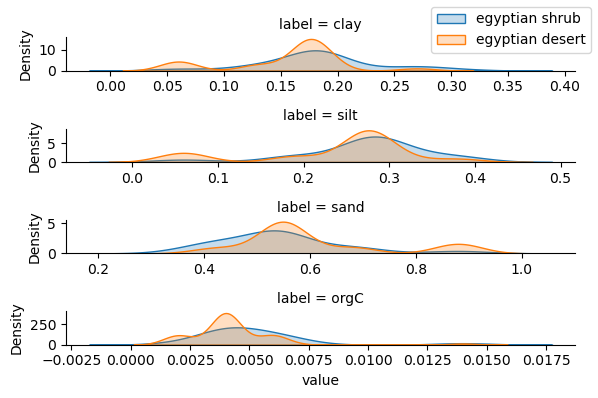

In [71]:
region_egypt_shrub = region_train_3 & (data_index_2['Biome_obs']==16)
region_egypt_desert = region_train_3 & (data_index_2['Biome_obs']==17)
show_feature_distribution(features_nonweather, [region_egypt_shrub, region_egypt_desert], ['egyptian shrub','egyptian desert'])
save_plot(plt.gcf(), 'egypt_shrub_desert_soil')

Plot a map

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


1


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


2


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


3


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


5


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


6


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


7


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


8


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


9


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


10


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


11


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


12


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


13


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


14


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


15


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


16


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


17


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


18


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


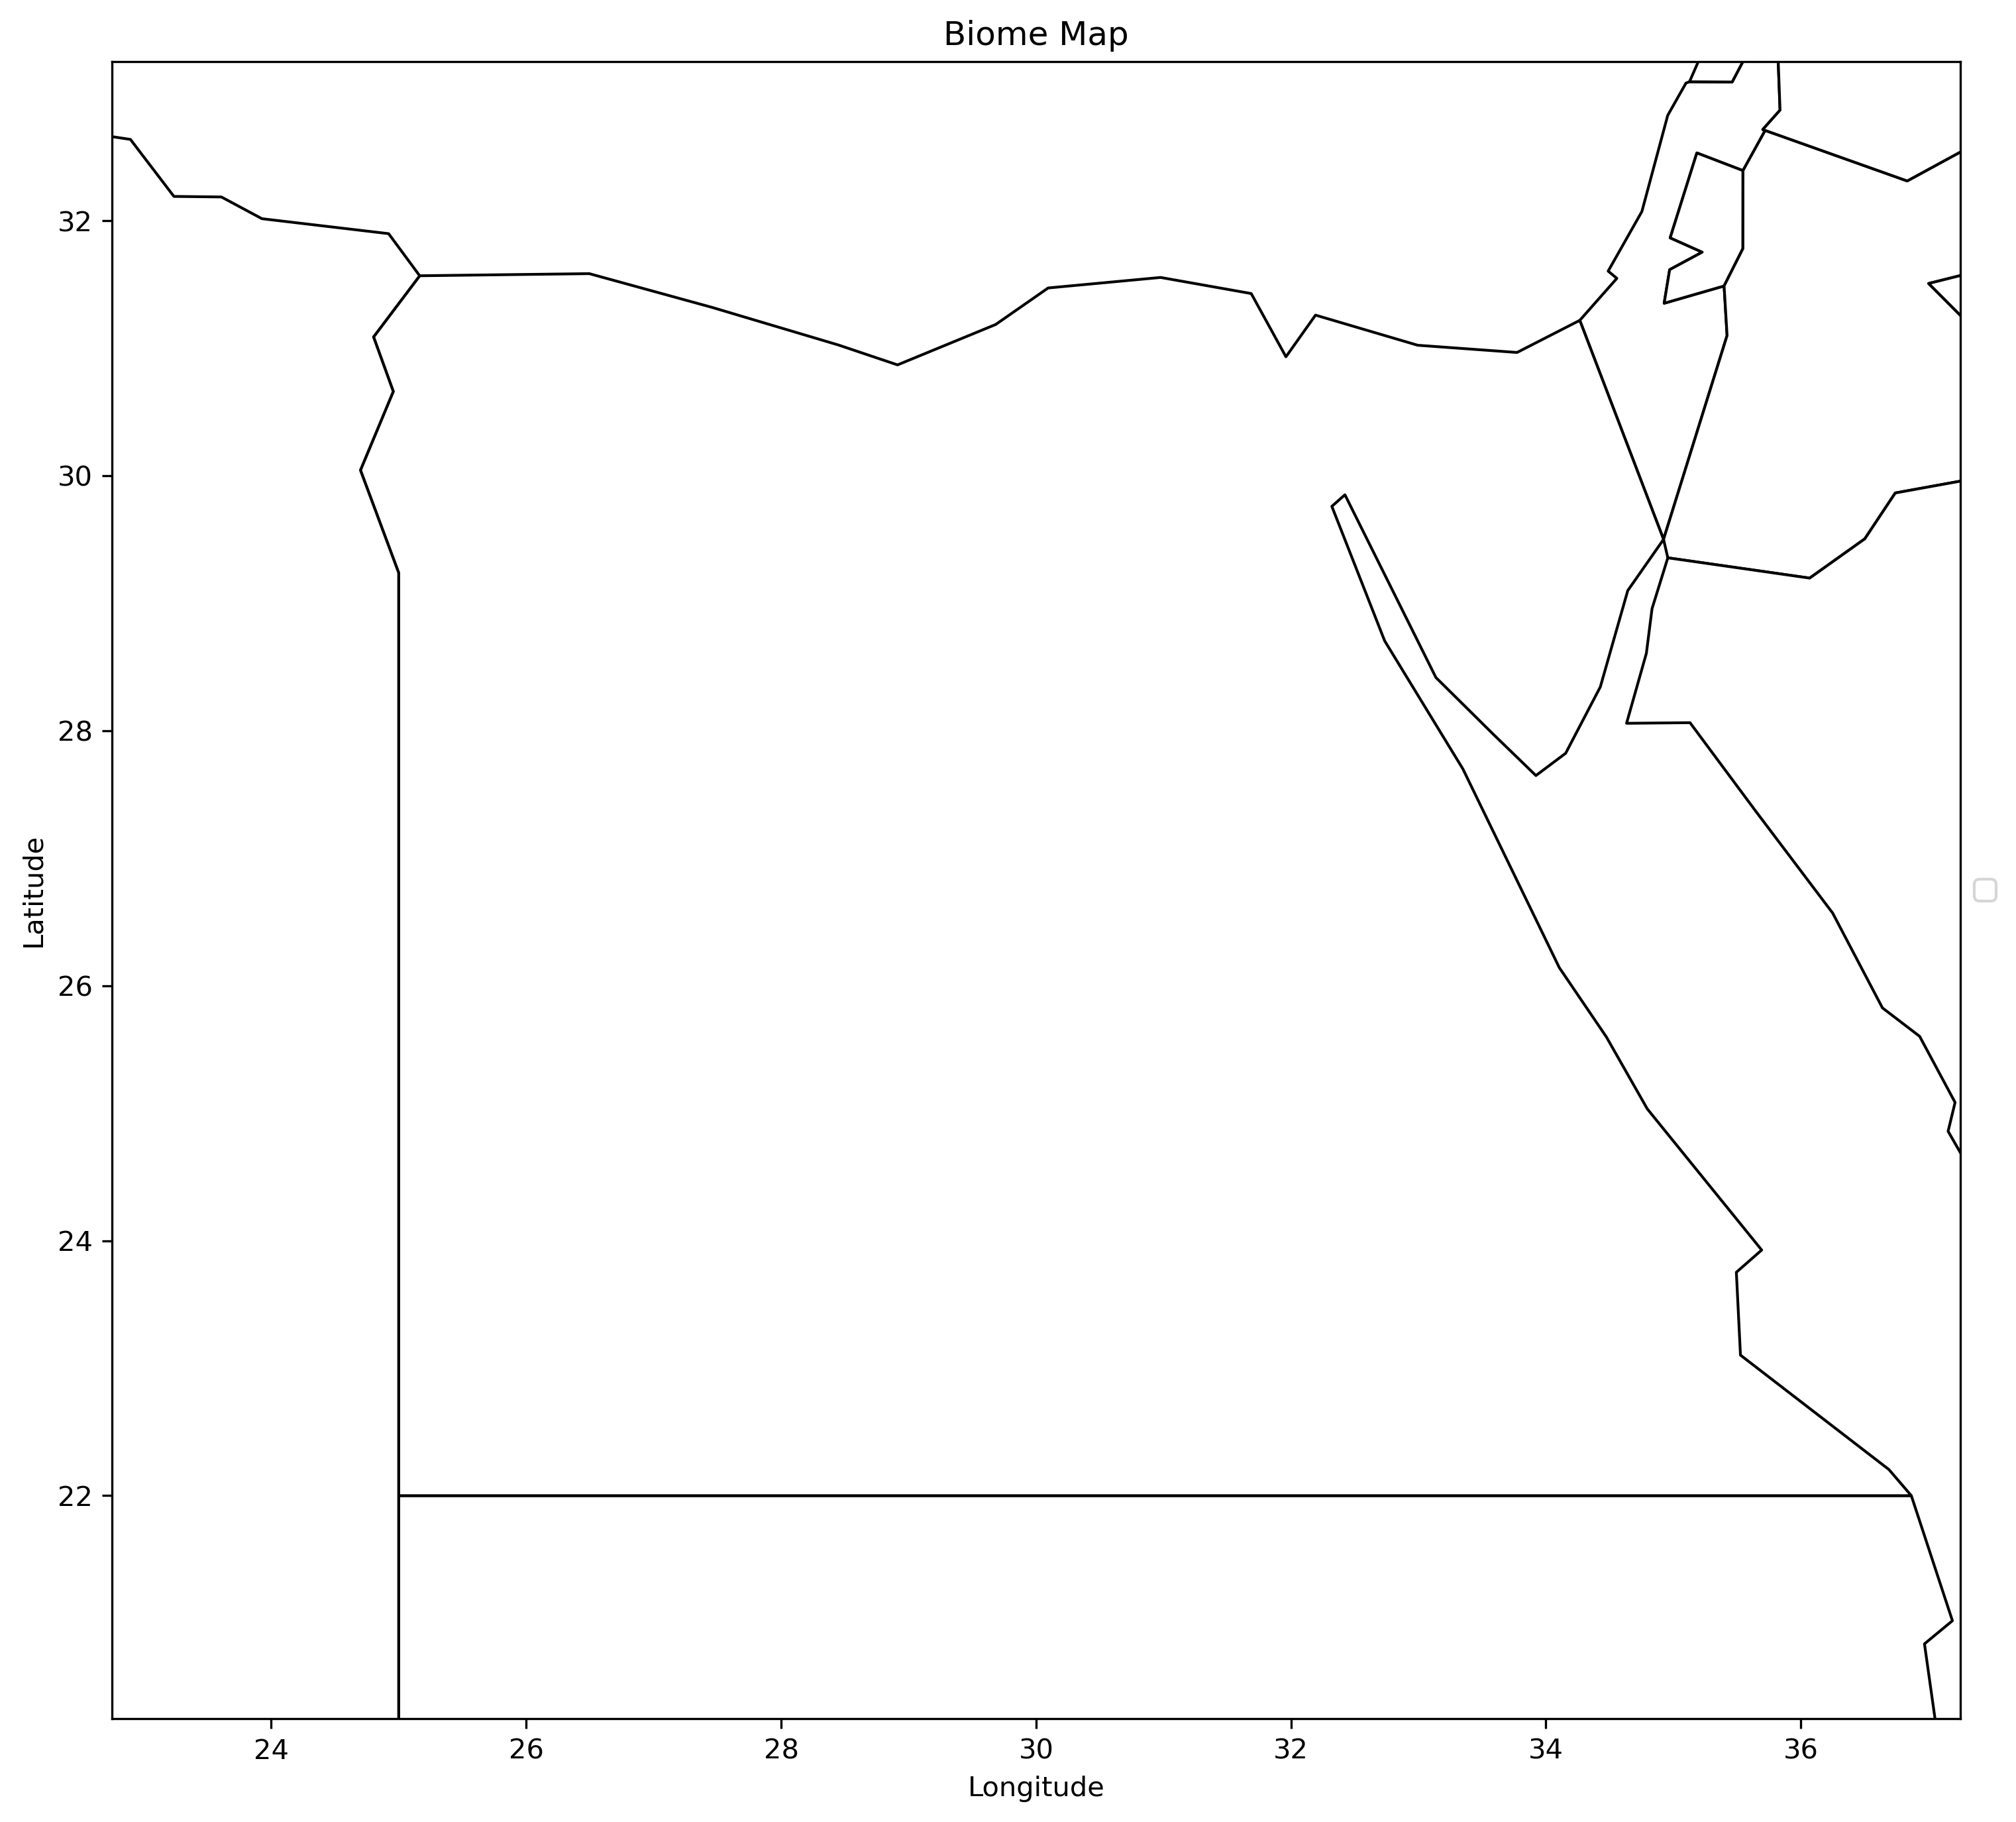

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


1


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


2


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


3


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


5


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


6


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


7


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


8


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


9


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


10


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


11


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


12


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


13


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


14


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


15


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


16


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


17


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


18


Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

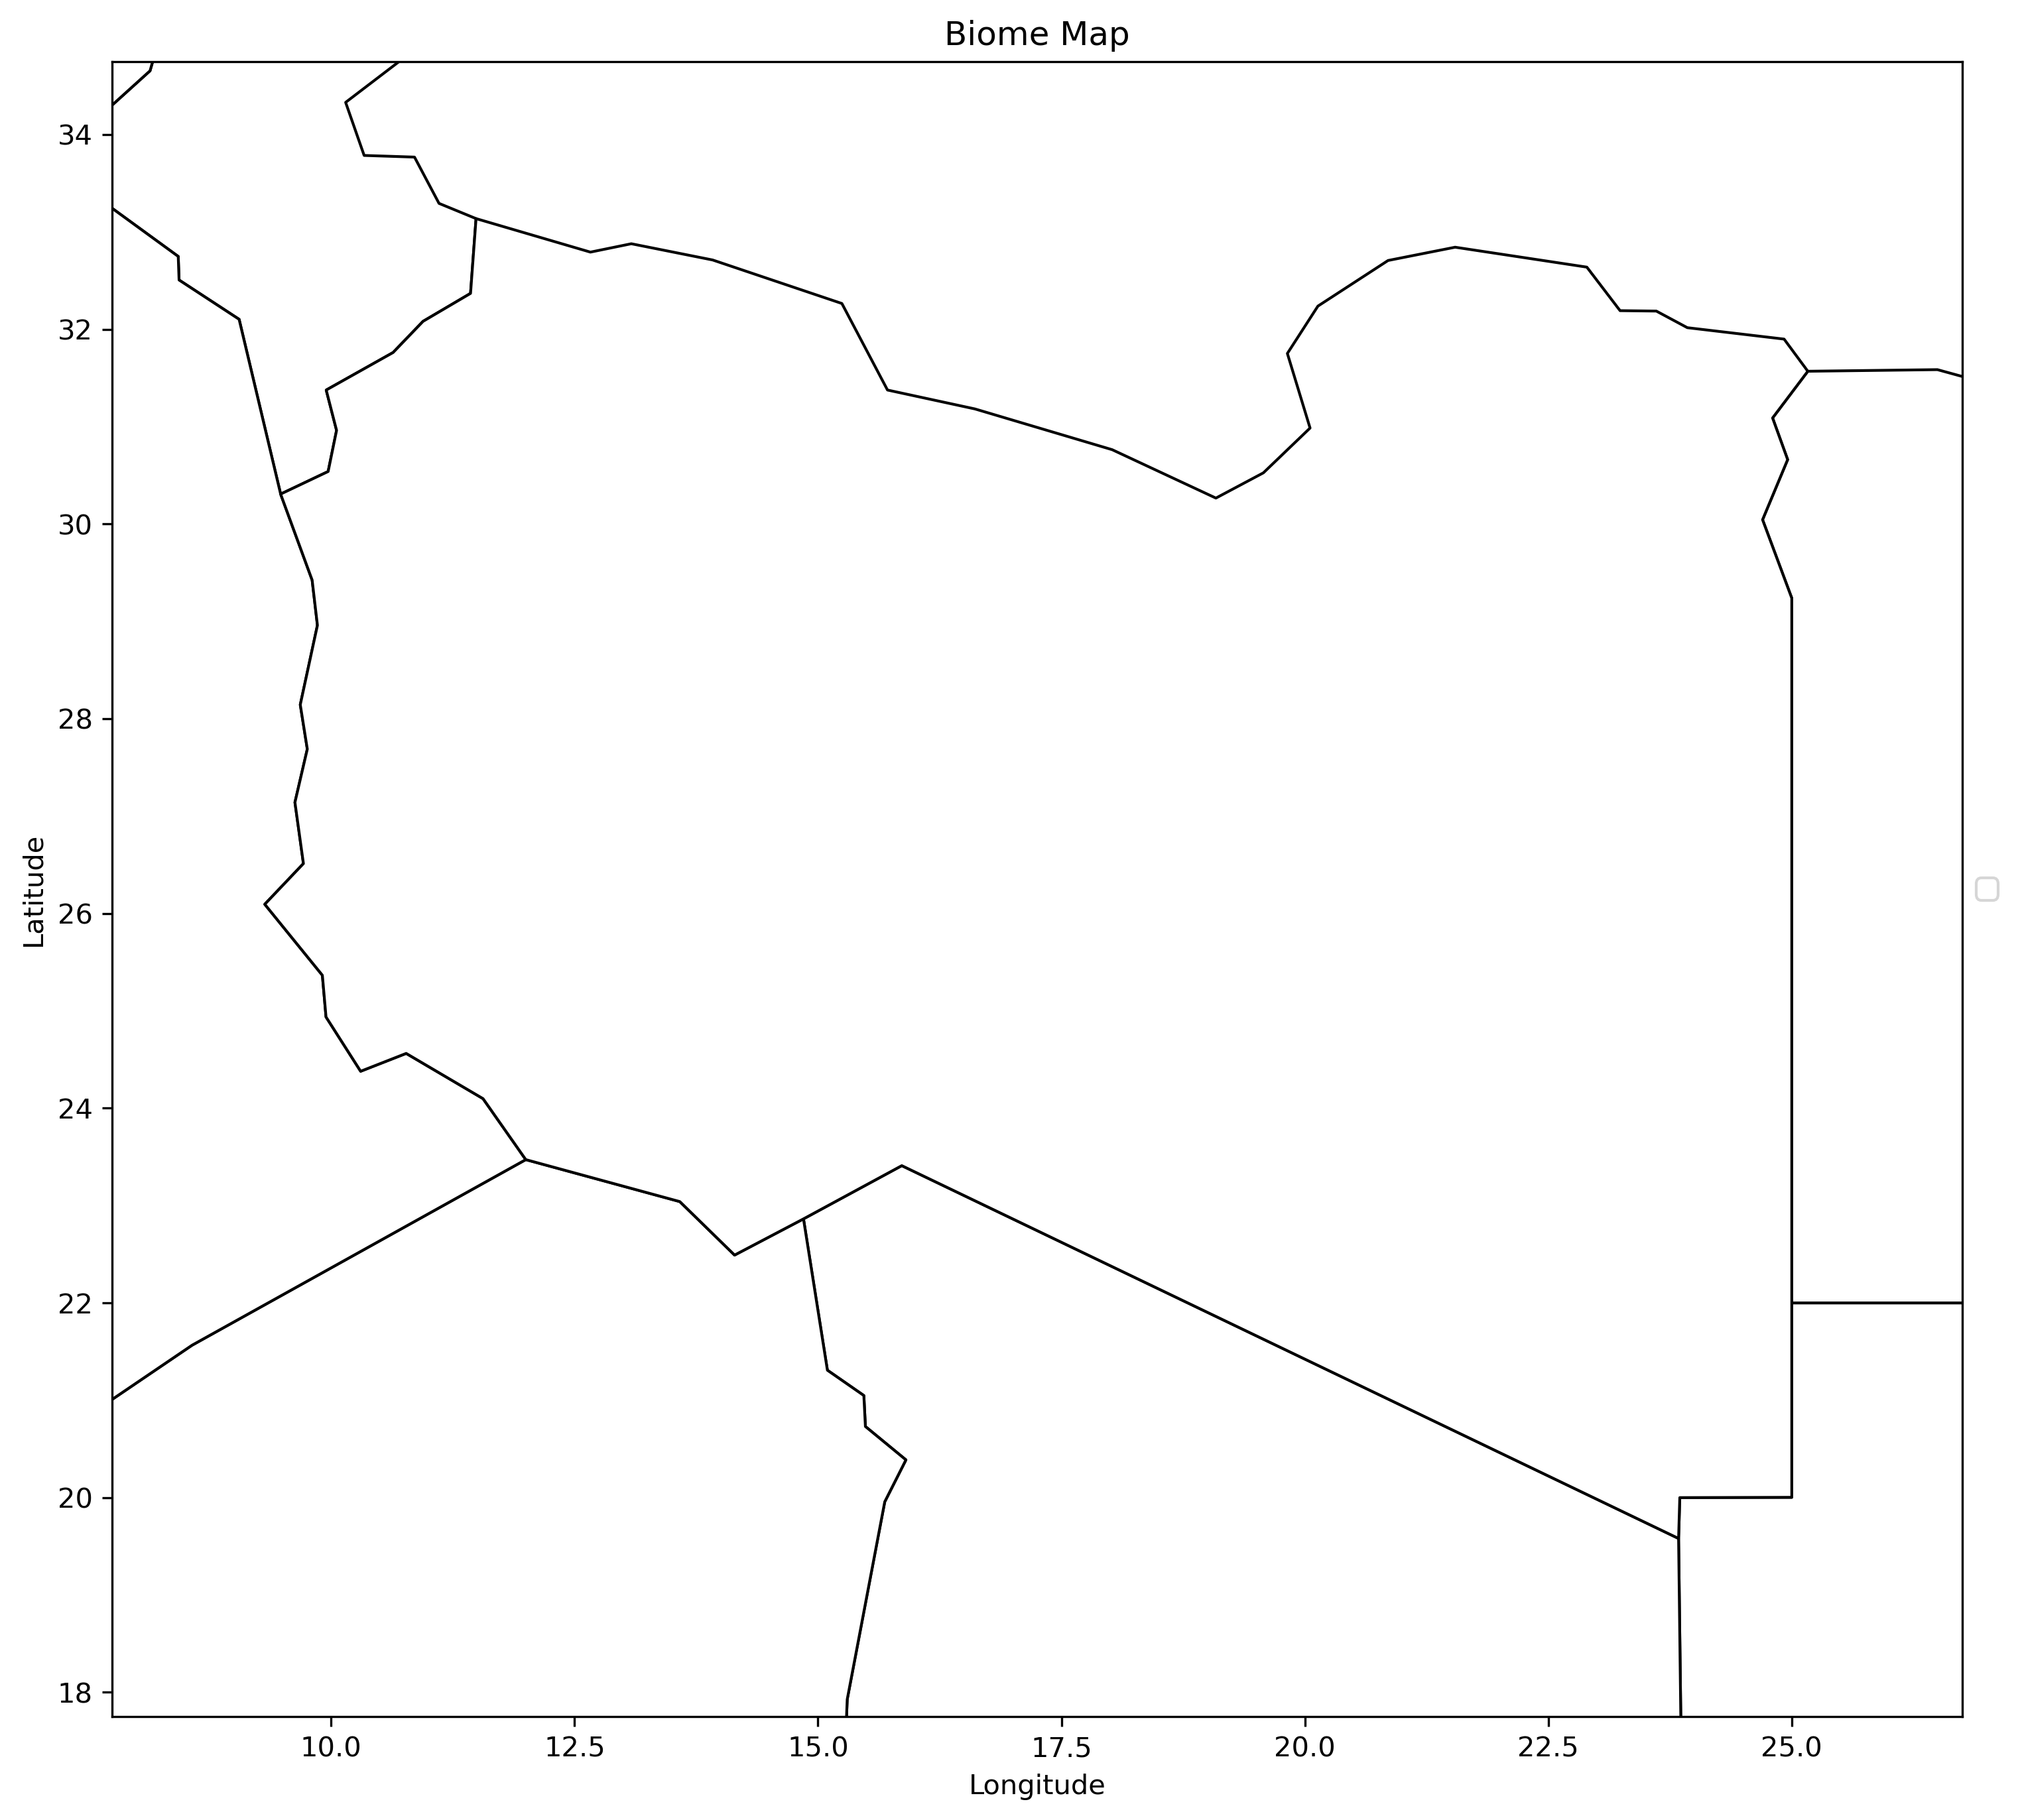

<Figure size 640x480 with 0 Axes>

In [114]:
plot_region(region_train_3, plot_name='egypt')
plot_region(region_test_3, plot_name='libya')

Here the action starts.

length of training data: 326
length of testing data: 509


Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9509 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9607
Balanced accuracy of RandomForestClassifier on train data: 0.8485


---
 The confusion table

Truth,16,17
Predicted,,
16,46,0
17,20,443


,precision,recall,f1-score,support
16,1.000000,0.696970,0.821429,66.000000
17,0.956803,1.000000,0.977925,443.000000
accuracy,0.960707,0.960707,0.960707,0.960707
macro avg,0.978402,0.848485,0.899677,509.000000
weighted avg,0.962405,0.960707,0.957633,509.000000


---
 The feature importance

,importance
Pre_WinterMean,0.091131
Pre_SpringMedian,0.069460
Pre_WinterMedian,0.068652
Pre_WinterStd,0.042421
Pre_SpringStd,0.038069
...,...
tmin_SummerStd,0.002586
silt,0.002279
tmax_SummerStd,0.002244
tswrf_WinterStd,0.002165


The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


1
2
3


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


5
6
7
8
9
10
11
12
13
14
15
16
17


The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


18


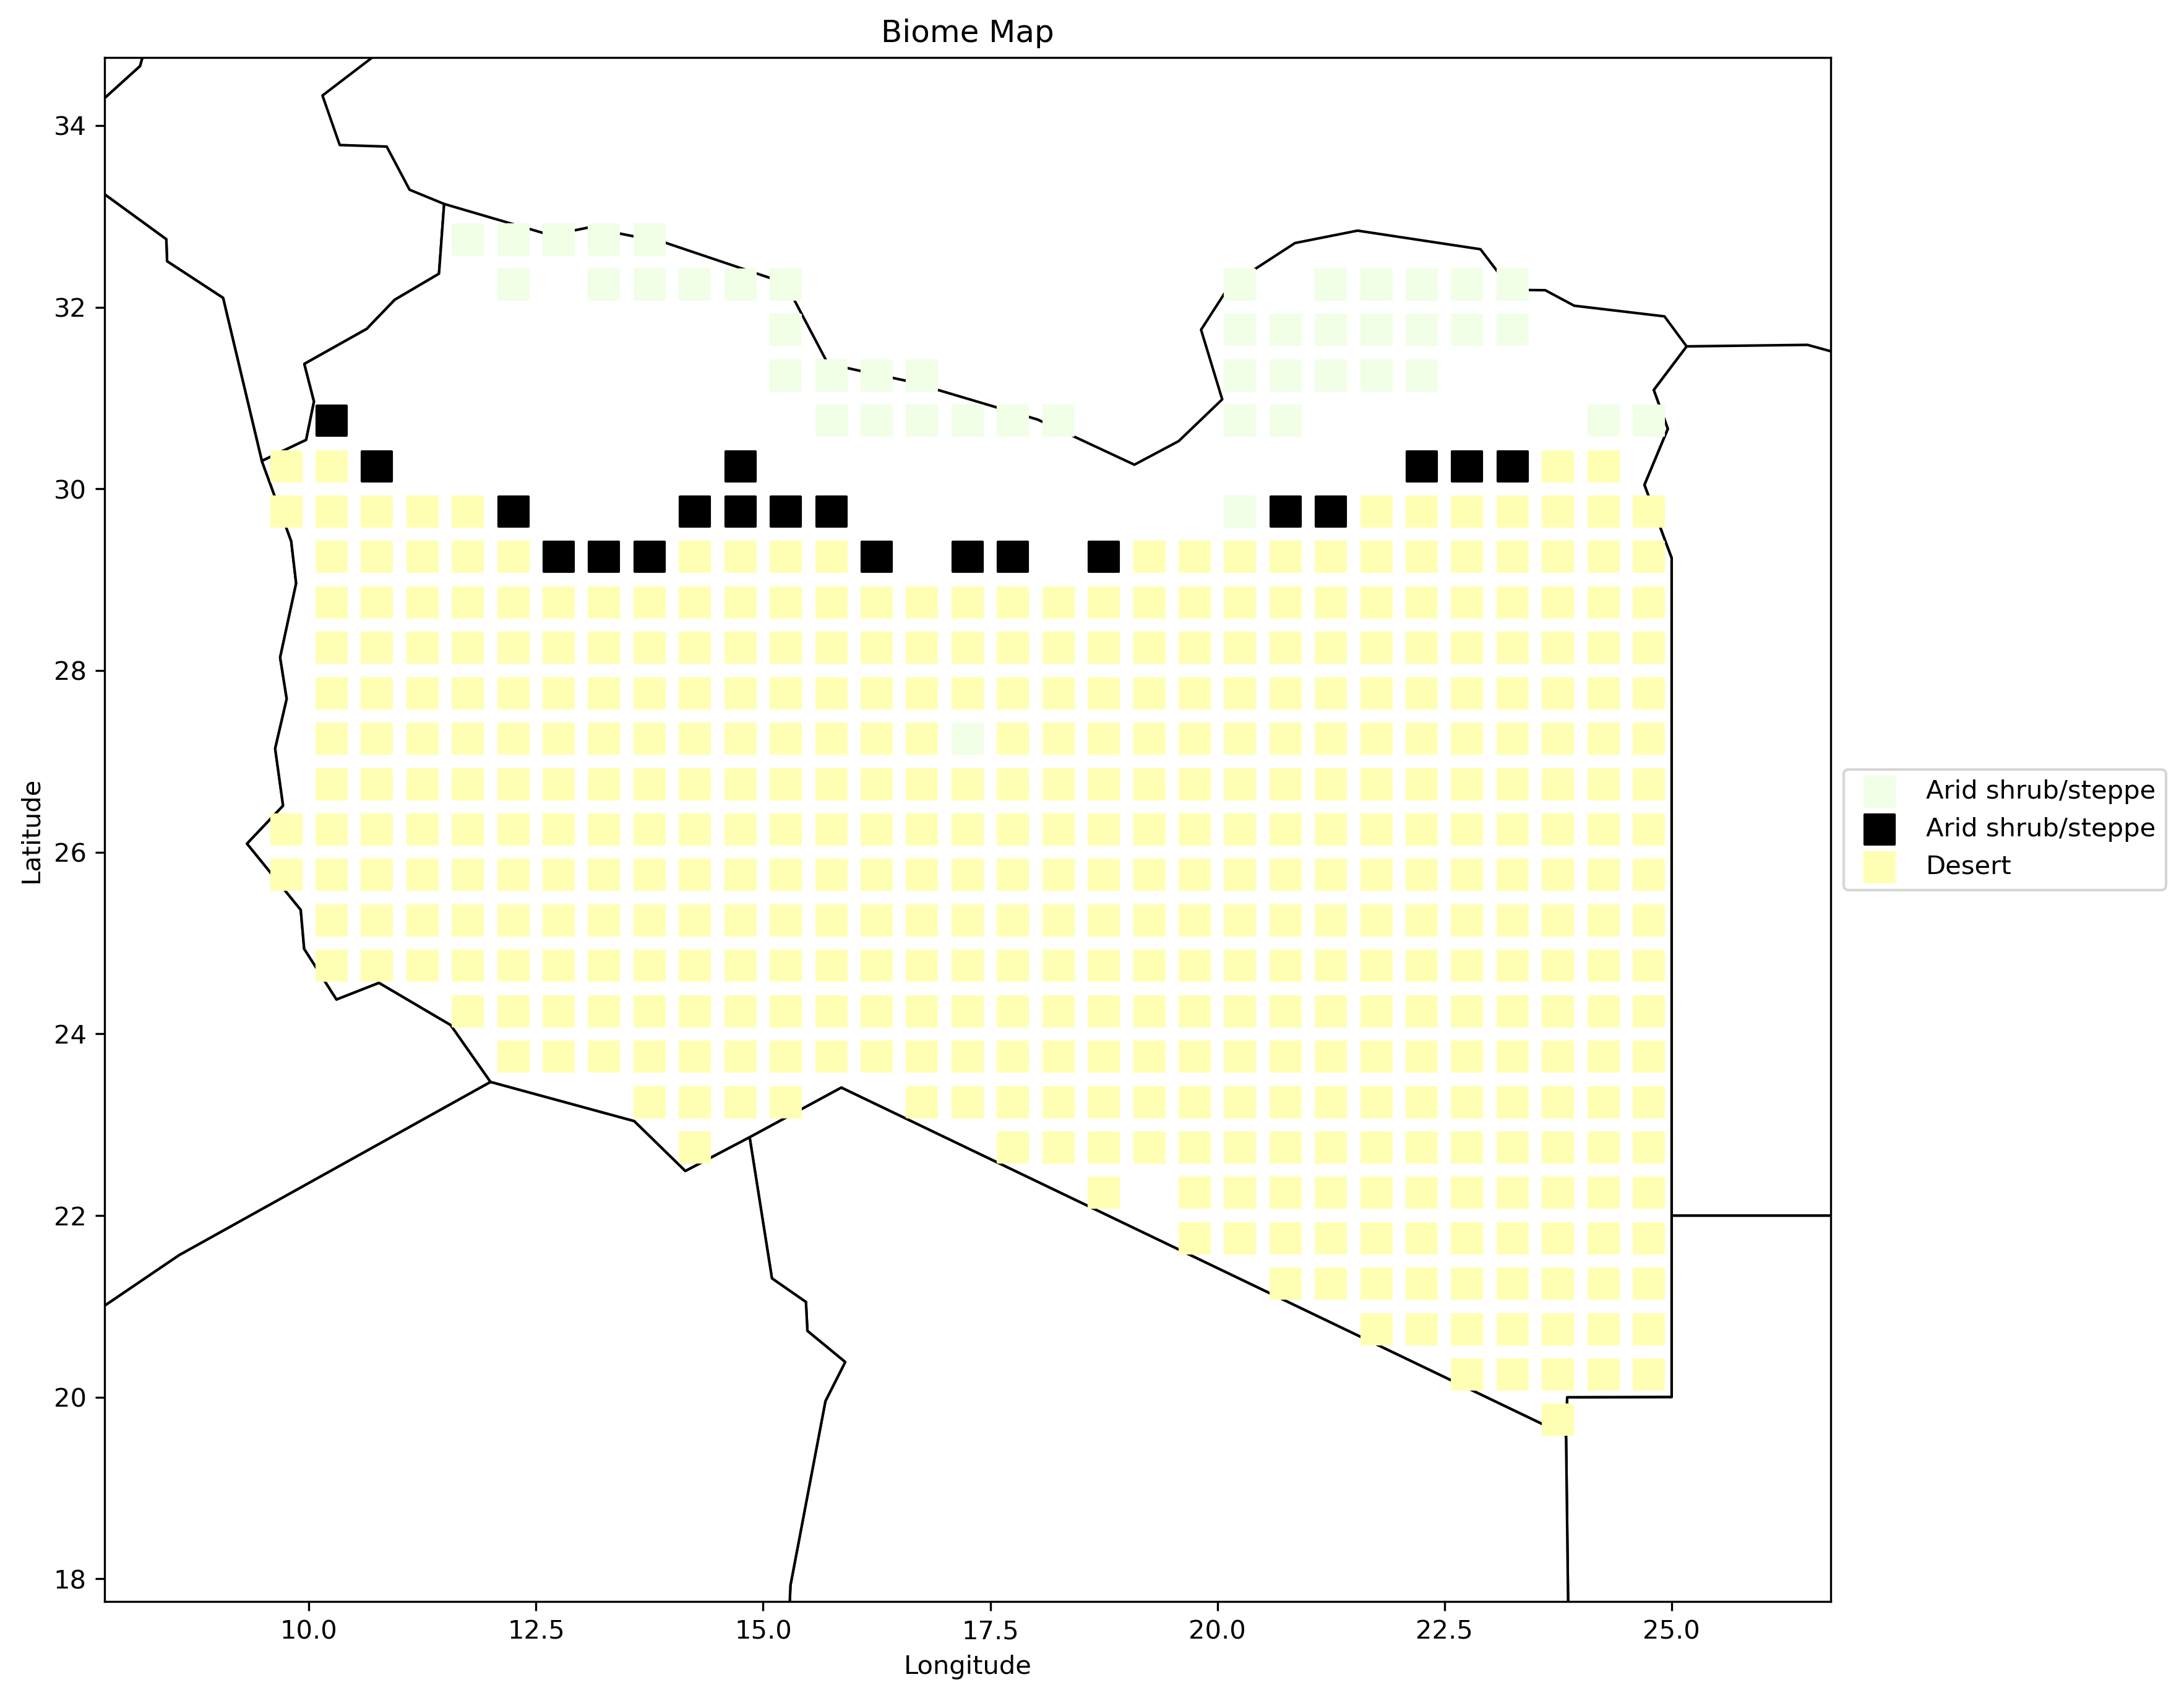

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

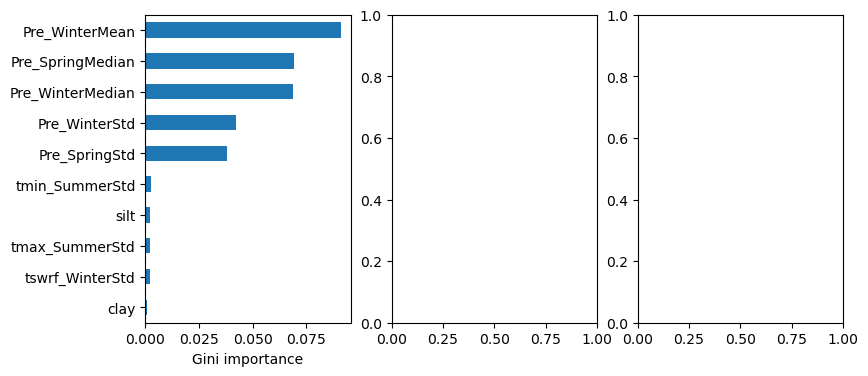

In [154]:
model_run(region_train_3, region_test_3, objective_list=biome_list_3, feature_plots=True, experiment_name='s3_basic', plotmap=True)

And now run a series of tests, collecting data.

Now run a series of tests, collecting data.

In [ ]:
%%capture
performance = model_run(region_train_3, region_test_3, objective_list=biome_list_3, experiment_name='s3_basic')
simulation_comparisons_3 = pd.DataFrame([['base']+performance], columns=['experiment name','accuracy, train', 'balanced accuracy, train', 'cross val accuracy, train',
            'accuracy, test', 'balanced accuracy, test'])

for i,feature_name in enumerate(features_names):
    display(Markdown('---'))
    print(f'Dropping season {feature_name}')
    print(f'We dropped the features: {drop_features[i]}')
    performance = model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
               drop_columns=drop_features[i], experiment_name=f's3_drop_{feature_name.replace("|","_")}')
    
    simulation_comparisons_3 = pd.concat([simulation_comparisons_3, pd.DataFrame([[f'drop {feature_name}']+performance], columns=list(simulation_comparisons_3))])
    

In [ ]:
simulation_comparisons_3.to_pickle('../data/simulation_comparisons_3.pkl')

In [ ]:
def plot_comparisons_data(simulation_comparisons, experiment_name=None):
    simulation_comparisons['error rate, test']= 1-simulation_comparisons['accuracy, test']
    ax = sns.barplot(simulation_comparisons[['experiment name','error rate, test']], x='experiment name', y='error rate, test')
    ax.set_ylabel('Error rate')
    ax.set_xlabel('')
    plt.axhline(y=simulation_comparisons['error rate, test'][0], color='blue',linestyle='--')
    plt.xticks(rotation=90);
    if experiment_name: save_plot(plt.gcf(), f'{experiment_name}_simulationComparisons_errorRate')

    plt.subplots()
    simulation_comparisons['balanced error rate, test'] = 1-simulation_comparisons['balanced accuracy, test']
    ax = sns.barplot(simulation_comparisons[['experiment name','balanced error rate, test']], x='experiment name', y='balanced error rate, test')
    ax.set_ylabel('Balanced error rate')
    ax.set_xlabel('')
    plt.axhline(y=simulation_comparisons['balanced error rate, test'][0], color='blue',linestyle='--')
    plt.xticks(rotation=90);
    if experiment_name: save_plot(plt.gcf(), f'{experiment_name}_simulationComparisons_balancedErrorRate')

In [ ]:
simulation_comparisons_3 = simulation_comparisons_3.reset_index(drop=True)
plot_comparisons_data(simulation_comparisons_3, 's3')

## Section 4: Multiclass classification

Because of the significant negative impact on the learning outcome by choosing regions at very different latitudes we chose as regions
- for training: Russia
- for testing: Canada

In [ ]:
region_train_4 = data_index_2['Pan_2007'] == 'Russia'
region_test_4 = data_index_2['Pan_2007'] == 'Canada'

In [ ]:
# plot the data
data1 = data_index_2.loc[region_train_4] 
data2 = data_index_2.loc[region_test_4]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section4Canada_Russia')

And now we run the simulation

In [ ]:
model_run(region_train_4, region_test_4, experiment_name='s4_basic', feature_plots=True, plotmap=True)

This is relatively bad performance. Fiddling with the hyperparameters changes a lot though the
hyperparameter optimisation is far from optimal. Let's see how good it is.

In [55]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True, experiment_name = 'Tuning')

length of training data: 11696
length of testing data: 6497


KeyboardInterrupt: 

It's not too good in this case. But when we were previously comparing Africa with China fiddling with the parameters actually did improve things. In the following we will thus disable the hyperparameter tuning. Let's try dropping various features and see how that impacts performance.

In [ ]:
%%capture
performance = model_run(region_train_4, region_test_4, experiment_name='s4_basic')
simulation_comparisons_4 = pd.DataFrame([['base']+performance], columns=['experiment name','accuracy, train', 'balanced accuracy, train', 'cross val accuracy, train',
            'accuracy, test', 'balanced accuracy, test'])

for i,feature_name in enumerate(features_names):
    display(Markdown('---'))
    print(f'Dropping season {feature_name}')
    print(f'We dropped the features: {drop_features[i]}')
    performance = model_run(region_train_4, region_test_4, \
               drop_columns=drop_features[i], experiment_name=f's4_drop_{feature_name.replace("|","_")}')
    
    simulation_comparisons_4 = pd.concat([simulation_comparisons_4, pd.DataFrame([[f'drop {feature_name}']+performance], columns=list(simulation_comparisons_4))])

In [ ]:
simulation_comparisons_4 = simulation_comparisons_4.reset_index(drop=True)
simulation_comparisons_4.to_pickle('../data/simulation_comparisons_4.pkl')

In [ ]:
plot_comparisons_data(simulation_comparisons_4, 's4')

Let's see how things are with biome_Cmax.

In [ ]:
model_run(region_train_4, region_test_4, feature_plots = True, objective='Biome_Cmax', experiment_name = 'Basic_with_Biome_Cmax')

In [ ]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True, feature_plots = False, objective='Biome_Cmax', experiment_name = 's4Basic_with_Biome_Cmax')

In [65]:
%%capture
performance = model_run(region_train_4, region_test_4, objective='Biome_Cmax', experiment_name='s4_basic')
simulation_comparisons_4 = pd.DataFrame([['base']+performance], columns=['experiment name','accuracy, train', 'balanced accuracy, train', 'cross val accuracy, train',
            'accuracy, test', 'balanced accuracy, test'])

for i,feature_name in enumerate(features_names):
    display(Markdown('---'))
    print(f'Dropping season {feature_name}')
    print(f'We dropped the features: {drop_features[i]}')
    performance = model_run(region_train_4, region_test_4, objective='Biome_Cmax',\
               drop_columns=drop_features[i], experiment_name=f's4_drop_{feature_name.replace("|","_")}')
    
    simulation_comparisons_4 = pd.concat([simulation_comparisons_4, pd.DataFrame([[f'drop {feature_name}']+performance], columns=list(simulation_comparisons_4))])

In [66]:
simulation_comparisons_4 = simulation_comparisons_4.reset_index(drop=True)
simulation_comparisons_4.to_pickle('../data/simulation_comparisons_4_Cmax.pkl')

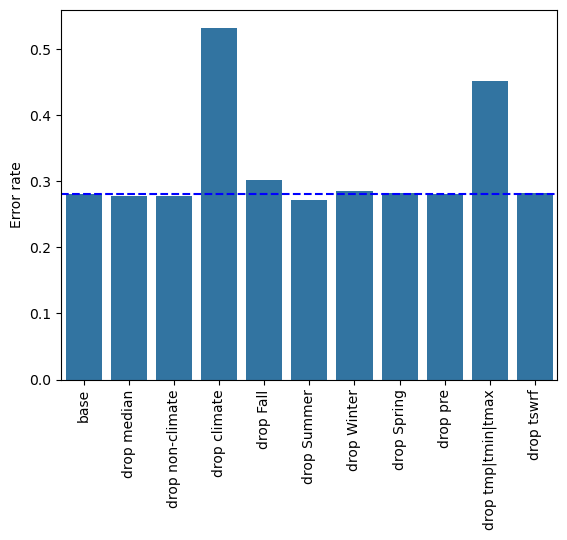

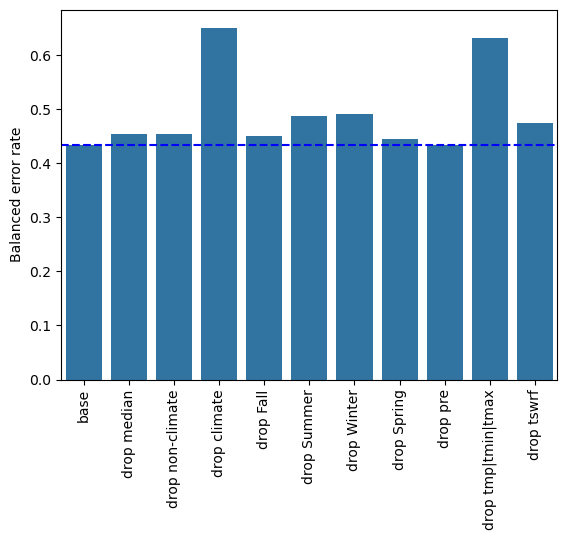

In [67]:
plot_comparisons_data(simulation_comparisons_4, 's4_cCmax')

Plot for different features:

In [ ]:
model_run(region_train_4, region_test_4, drop_columns=features_weather, objective='Biome_Cmax', experiment_name='s4_with_Biome_dropWeather')

In [ ]:
model_run(region_train_4, region_test_4, use_columns=features_weather, objective='Biome_Cmax', experiment_name='s4_with_Biome_useWeather')

That is quite decent performance though not as good as with biome_obs.

### Section 4.6

Test the model trained with 'Biome_Cmax' on 'Biome_obs'.

In [ ]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax', objective_test='Biome_obs')

Who would have thought? The model performs as badly as an antigen test measuring temperature. Now test the model trained on 'Biome_obs' on 'Biome_Cmax' (and expect a similar result).

In [ ]:
model_run(region_train_4, region_test_4, objective='Biome_obs', objective_test='Biome_Cmax')

... and the result is just as bad. What a surprise. Now compare our model with LPJ-Guess output

In [ ]:
for objective in ['Biome_obs','Biome_Cmax']:
    print(f'Comparing LPJ-Guess with our model for the parameter {objective}')
    model_run(region_train_4, region_test_4, objective=objective, objective_test=f'LPJ_{objective}')

Who would have thought that our model works badly in this case (duh)?

## Section 5: Regression 

In this part we creatively use the same test and validation set as in part 4. Though we swap order because of performance issues

In [7]:
region_train_5 = data_index_2['Pan_2007'] == 'Canada'
region_test_5 = data_index_2['Pan_2007'] == 'Russia'

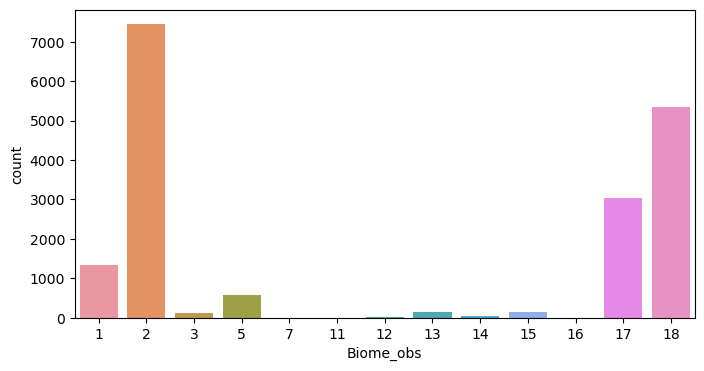

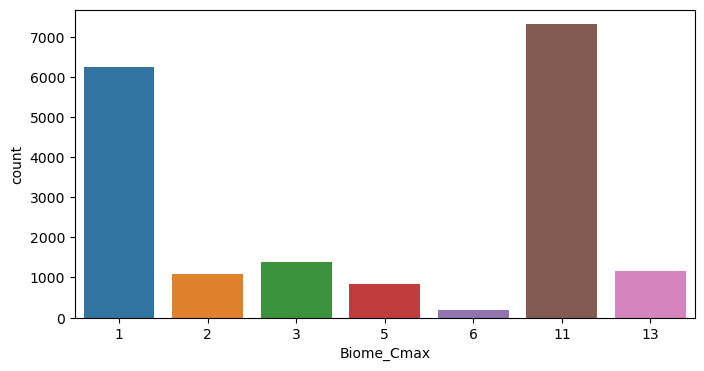

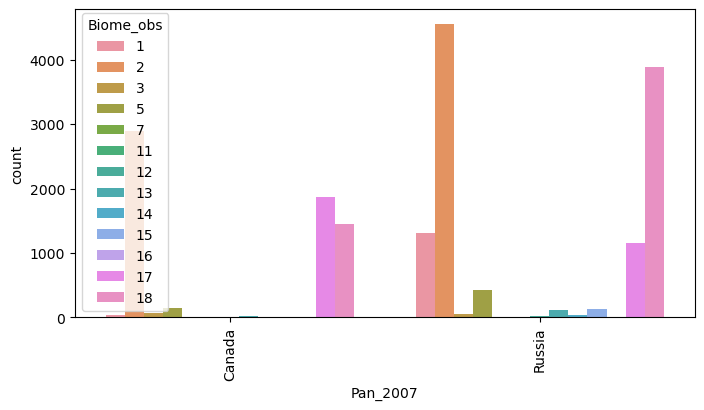

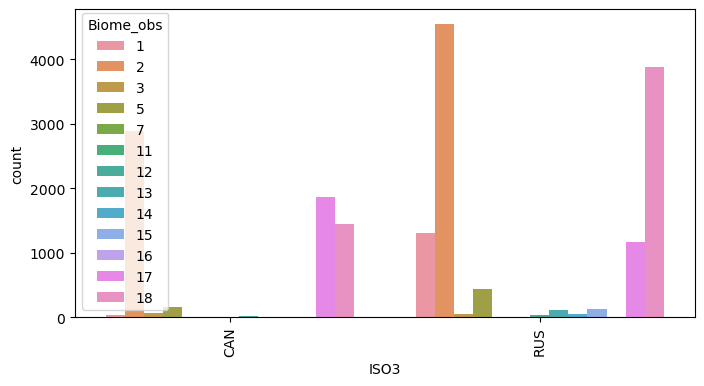

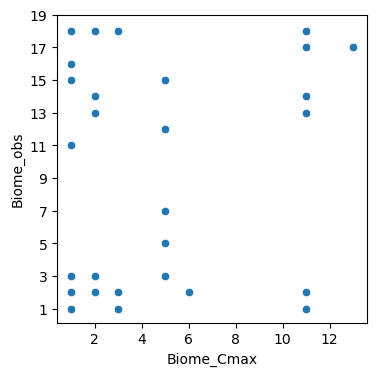

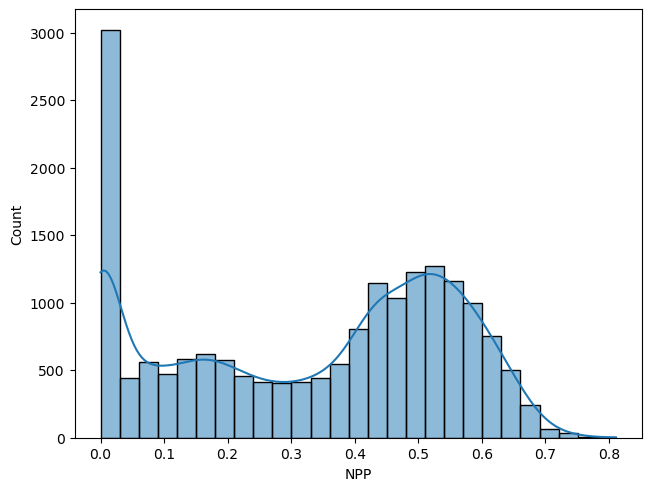

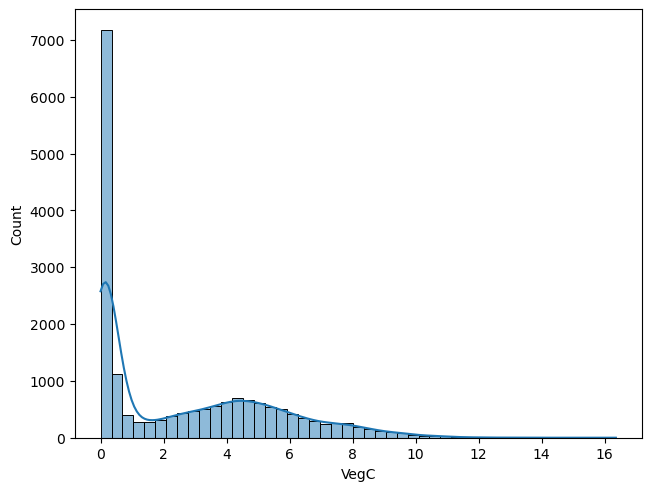

In [13]:
# plot the data
data1 = data_index_2.loc[region_train_5] 
data2 = data_index_2.loc[region_test_5]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section5Canada_Russia')

The figure layout has changed to tight


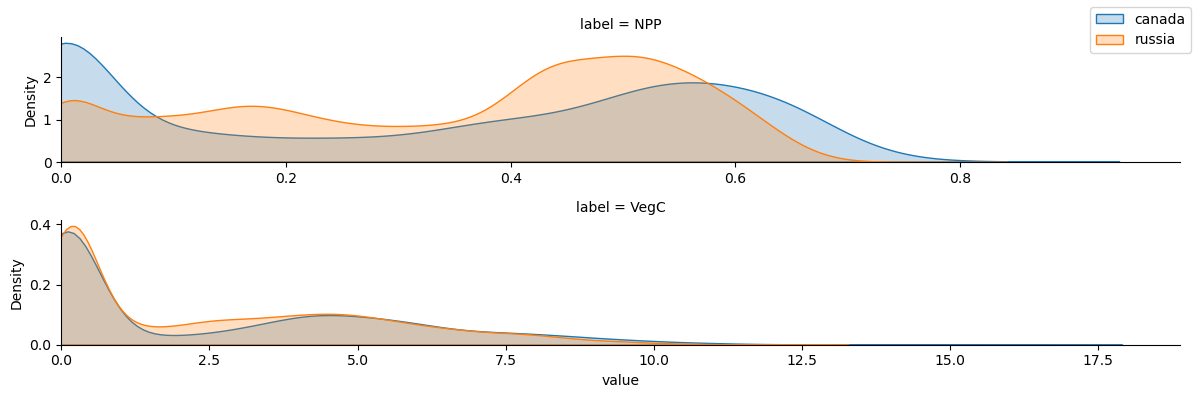

In [19]:
show_feature_distribution(['NPP','VegC'], [region_train_5, region_test_5], ['canada','russia'], height=2)
fig=plt.gcf()
fig.axes[0].set_xlim(xmin=0)
fig.axes[1].set_xlim(xmin=0)
save_plot(plt.gcf(), 'npp_vegc_distribution')

And we run the model.

length of training data: 6499
length of testing data: 11696
R^2 Score of RandomForestRegressor on train data: 0.9977
R^2 Score of RandomForestRegressor on test data: 0.8353
MSE for test data 0.006449696506267102
MSE (with sktfct) for test  data 0.006449696506267102
sqrt(MSE) for test data 0.08031000252936804
max error for test data 0.39611
mean abs error for test data 0.06153288218194254


The figure layout has changed to tight
The figure layout has changed to tight


---
 The feature importance

,importance
tmin_SummerMean,0.394795
tmax_SummerMedian,0.373563
tmp_FallMedian,0.061825
tmp_SummerMedian,0.060241
tmin_SummerMedian,0.023700
...,...
tmax_SpringMean,0.000368
tmin_WinterMedian,0.000309
silt,0.000303
orgC,0.000286


5531.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5531.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


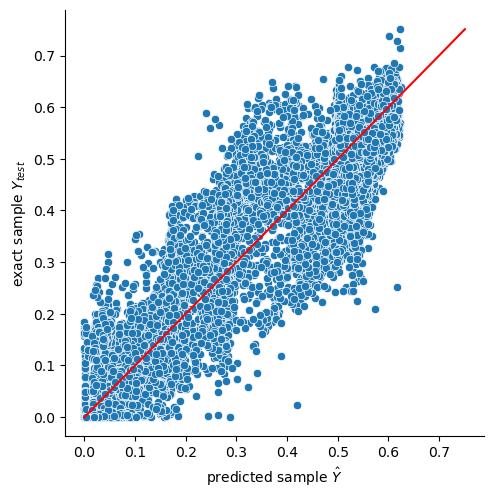

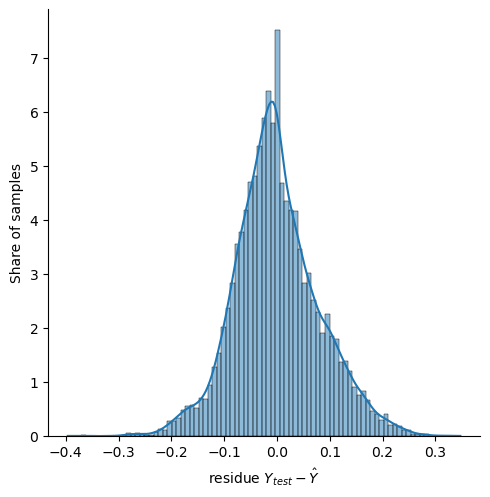

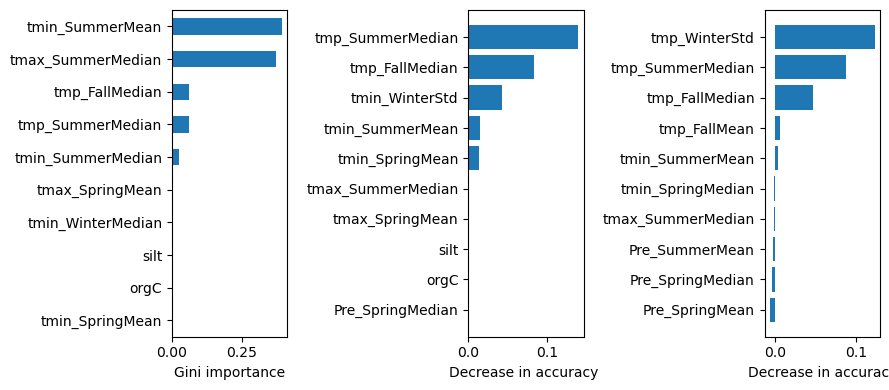

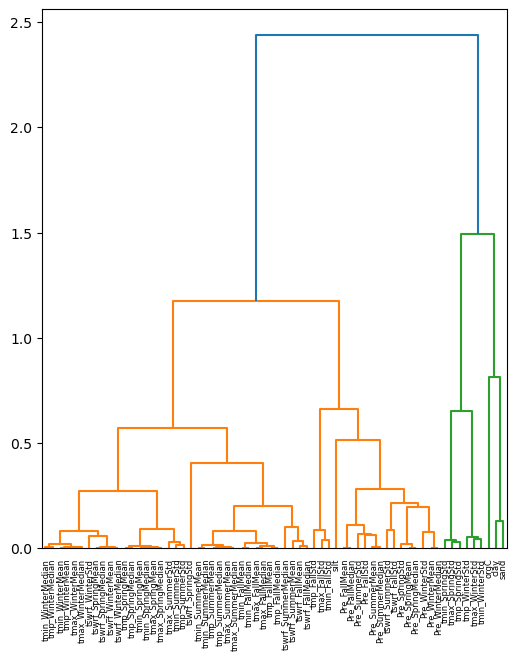

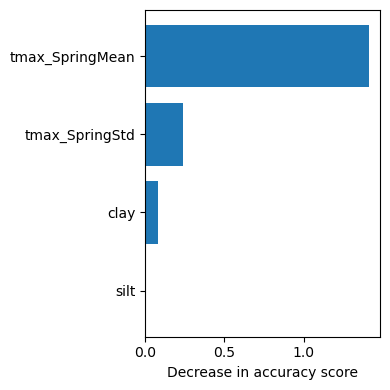

---

[0.9976601688509646,
 0.8352849123069679,
 0.006449696506267102,
 0.006449696506267102,
 0.08031000252936804,
 0.39611,
 0.06153288218194254]

In [31]:
model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, feature_plots=True, experiment_name='s5_npp_basic')

A pretty decent outcome. Let's see how it behaves with 'VegC'.

length of training data: 6499
length of testing data: 11696
R^2 Score of RandomForestRegressor on train data: 0.9902
R^2 Score of RandomForestRegressor on test data: 0.6942
MSE for test data 2.191245235723247
MSE (with sktfct) for test  data 2.191245235723247
sqrt(MSE) for test data 1.4802855250671227
max error for test data 8.44752
mean abs error for test data 0.9382680412106703


The figure layout has changed to tight
The figure layout has changed to tight


---
 The feature importance

,importance
tmin_SummerMedian,0.522966
tmax_SummerMedian,0.132425
tmp_SummerMedian,0.072798
Pre_SummerMean,0.037299
Pre_SpringMean,0.033648
...,...
orgC,0.000617
tmin_SpringMedian,0.000493
clay,0.000332
sand,0.000329


3954.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3955.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3955.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


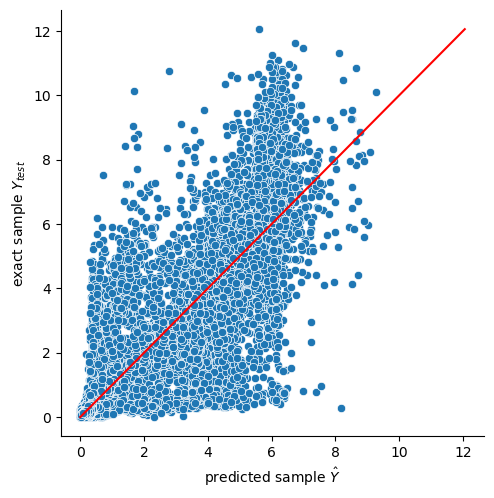

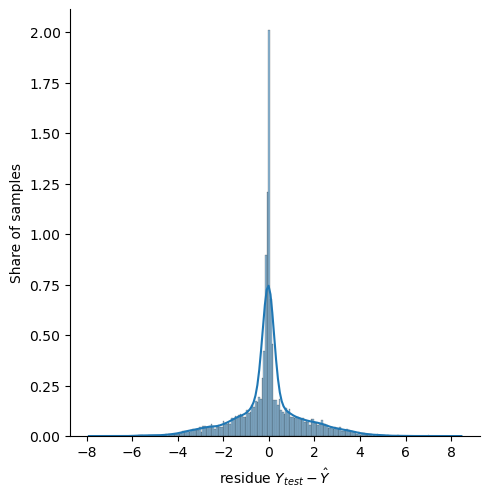

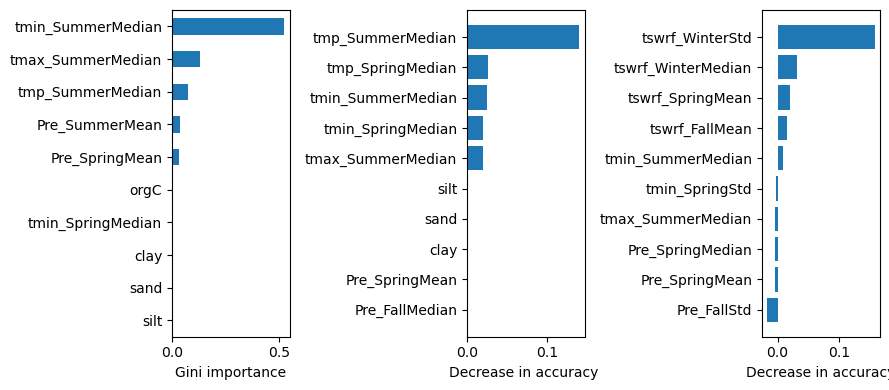

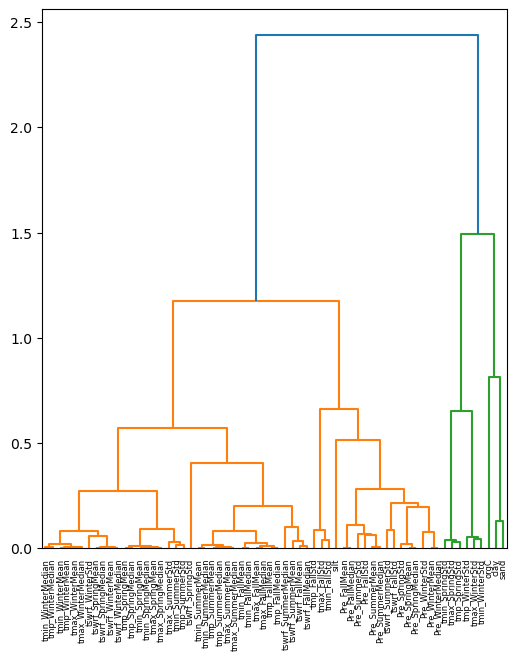

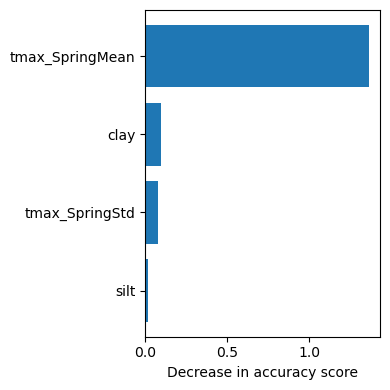

---

[0.9901868742258442,
 0.6942498327493074,
 2.191245235723247,
 2.191245235723247,
 1.4802855250671227,
 8.44752,
 0.9382680412106703]

In [29]:
model_run(region_train_5, region_test_5, objective='VegC', continuous_Y=True, feature_plots=True, experiment_name='s5_vegc_basic')

'VegC' seems to perform worse. In the following we focus on NPP. What happens if we drop the medians?

In [30]:
%%capture
performance = model_run(region_train_5, region_test_5, experiment_name='s5_basic', continuous_Y=True)
simulation_comparisons_5 = pd.DataFrame([['base']+performance], columns=['experiment name', 'R^2 score, train', 'score, test',
             'MSE, test', 'MSE sktfct, test', 'sqrt(MSE)', 'max err', 'mean abs err'])

for i,feature_name in enumerate(features_names):
    display(Markdown('---'))
    print(f'Dropping season {feature_name}')
    print(f'We dropped the features: {drop_features[i]}')
    performance = model_run(region_train_5, region_test_5, continuous_Y=True, \
               drop_columns=drop_features[i], experiment_name=f's5_npp_drop_{feature_name.replace("|","_")}')
    
    simulation_comparisons_5 = pd.concat([simulation_comparisons_5, pd.DataFrame([[f'drop {feature_name}']+performance], columns=list(simulation_comparisons_5))])

NameError: name 'features_names' is not defined

In [ ]:
simulation_comparisons_5 = simulation_comparisons_5.reset_index(drop=True)
simulation_comparisons_5.to_pickle('../data/simulation_comparisons_5.pkl')

In [ ]:
list(simulation_comparisons_5)

In [ ]:
def plot_comparisons_data_regr(simulation_comparisons, experiment_name=None):
    simulation_comparisons['1-score, test']= 1-simulation_comparisons['score, test']
    labels = ['1-score, test','MSE, test', 'MSE sktfct, test', 'max err', 'mean abs err']
    ylabels = ['1-($R^2$ score)', 'MSE', 'MSE sktfct', 'Maximal error', 'Mean absolute error']
    plt_names = ['1_R2score','MSE','MSE_sktfct','MaxErr','MeanAbsErr']
    for i in range(len(labels)):
        plt.subplots()
        ax = sns.barplot(simulation_comparisons[['experiment name',labels[i]]], x='experiment name', y=labels[i])
        ax.set_ylabel(ylabels[i])
        ax.set_xlabel('')
        plt.axhline(y=simulation_comparisons[labels[i]][0], color='blue',linestyle='--')
        plt.xticks(rotation=90);
        if experiment_name: save_plot(plt.gcf(), f'{experiment_name}_simulationComparisons_{plt_names[i]}')

In [ ]:
plot_comparisons_data_regr(simulation_comparisons_5, 's5')

In [ ]:
df_to_latex(simulation_comparisons_5.drop(columns=['R^2 score, train', 'MSE, test', 'MSE sktfct, test']), 's5_experiment_comparison')